In [10]:
## April 10 2017
## Judy Fan (jefan@)
## DESIGN ## ## ## ## 
## There are four objects (bed, bench, chair, table). Participants viewed each object 20 times per run.
## Runs 1 & 2 -- reserved to conduct searchlight
## Runs 3 & 4 -- pretest phase 
## Four training runs involving practice drawing two of the trained objects. 
## Runs 5 & 6 -- posttest phase
## GOAL ## ## ## ## 
## Compare similarity between Trained object representations before and after training (vs. Control) in several
## anatomically-defined ROIs. To do this, define `representation' as cope maps generated 
## upon fitting GLM to each object for each run. Build object x voxel matrix (4xK) for each run, vertically concatenate
## the two runs in each phase, and compute correlation matrix. Consider M = off-diagonal 4x4 block [:4,4:8].
## Make sure the rows are sorted such that the first two are the Trained, and the last two are the Control objects.
## Now take the the top-left 2x2 matrix within M and let's call it M-trained. The bottom-right 2x2 = M-control.
## The diagonal elements of M-trained (A,D depicted below) reflect the representational similarity for the *same* object between runs.
## The off diagonal elements of M-trained (B,C) reflect the similarity between different objects across runs. 
## [_A_|_B_]
## [_C_|_D_]
## Mean of (B,C) - Mean(A,D) = Representational distance between objects in this phase. 
## Do the above for the pretest, then for the posttest, and compare.

## NOTE: On the 'sketchloop' machine, data are found in sketchloop02 directory at the same level as this 'neurosketch' 
## analysis directory, and are organized by subject. All the paths here are defined for the file organization on this 
## computer, so this code won't run as-is 

import warnings
warnings.filterwarnings('ignore')

In [11]:
import numpy as np
import glob
import os
import scipy.stats as stats
from sklearn import metrics
import matplotlib
matplotlib.use("Pdf")
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
import seaborn as sns

import brainiak
import nilearn
import nibabel
import json
from sklearn.metrics.pairwise import pairwise_distances as pd
from sklearn import svm
import sklearn
import analysis_helpers as helpers
import _pickle as cPickle
import pandas as pd 
from nilearn import image
from nilearn import plotting

## Setup

In [12]:
# load in experimental design pickle file

with open('morph_drawing_training_design.pkl', 'rb') as f:
    mdtd = cPickle.load(f, encoding='latin1') 

In [13]:
## cope numbering legend
## cope1 = 'bed'
## cope2 = 'bench'
## cope3 = 'chair'
## cope4 = 'table'

cope2obj = {'cope1':'bed','cope2':'bench', 'cope3':'chair','cope4':'table'}
obj2cope = {'bed':1,'bench':2, 'chair':3,'table':4}

In [14]:
# behavioral data from database
with open('versionNums.json') as json_data:
    coll = json.load(json_data)

In [15]:
## get list of subject directories

roi_dir = '/home/jgunn/neurosketch/surferROIs/'
cope_dir = '/home/jgunn/neurosketch/hires_copes'
contents_dir = os.listdir(roi_dir)

sub_dirs = []
for i in contents_dir:
    try:
        if i.split('_')[1]=='neurosketch':
            sub_dirs.append(i)
    except:
        pass

sub_dirs = sorted(sub_dirs)

# issue with 1207161
sub_dirs = [s for s in sub_dirs if s != '1207161_neurosketch']
sub_dirs = [s for s in sub_dirs if s != '1201161_neurosketch']

# need to fix ROIS for BRSA in order to include these
#sub_dirs = [s for s in sub_dirs if s != '0112171_neurosketch']
#sub_dirs = [s for s in sub_dirs if s != '1207162_neurosketch']

print(sub_dirs)
print(str(len(sub_dirs)) + ' subjects')

['0110171_neurosketch', '0110172_neurosketch', '0111171_neurosketch', '0112171_neurosketch', '0112172_neurosketch', '0112173_neurosketch', '0113171_neurosketch', '0115174_neurosketch', '0117171_neurosketch', '0118171_neurosketch', '0118172_neurosketch', '0119171_neurosketch', '0119172_neurosketch', '0119173_neurosketch', '0119174_neurosketch', '0120171_neurosketch', '0120172_neurosketch', '0120173_neurosketch', '0123171_neurosketch', '0123173_neurosketch', '0124171_neurosketch', '0125171_neurosketch', '0125172_neurosketch', '1121161_neurosketch', '1130161_neurosketch', '1202161_neurosketch', '1203161_neurosketch', '1206161_neurosketch', '1206162_neurosketch', '1206163_neurosketch', '1207162_neurosketch']
31 subjects


In [18]:
## Analysis helper functions (see and update: analysis_helpers.py)

def get_object_index(morphline,morphnum):
    furniture_axes = ['bedChair', 'bedTable', 'benchBed', 'chairBench', 'chairTable', 'tableBench']
    car_axes = ['limoToSUV','limoToSedan','limoToSmart','smartToSedan','suvToSedan','suvToSmart']  
    furniture_items = ['bed','bench','chair','table']
    car_items = ['limo','sedan','smartcar','SUV']               
    endpoints = mdr_helpers.getEndpoints(morphline)
    morphnum = float(morphnum)
    whichEndpoint = int(np.round(morphnum/100))
    thing = endpoints[whichEndpoint]
    if morphline in furniture_axes:
        return furniture_items.index(thing)+1
    elif morphline in car_axes:
        return car_items.index(thing)+1    
    
def getEndpoints(morphline):    
    if morphline=='sedanMinivan':
        return ['sedan','minivan']
    elif morphline=='minivanSportscar':
        return ['minivan','sportscar']
    elif morphline=='sportscarSUV':
        return ['sportscar','SUV']
    elif morphline=='SUVMinivan':
        return ['SUV','minivan']
    elif morphline=='sportscarSedan':
        return ['sportscar','sedan']
    elif morphline=='sedanSUV':
        return ['sedan','SUV']
    elif morphline=='bedChair':
        return ['bed','chair']
    elif morphline=='bedTable':
        return ['bed','table']
    elif morphline=='benchBed':
        return ['bench','bed']
    elif morphline=='chairBench':
        return ['chair','bench']
    elif morphline=='chairTable':
        return ['chair','table']
    elif morphline=='tableBench':
        return ['table','bench']
    elif morphline=='limoToSUV':
        return ['limo','SUV']    
    elif morphline=='limoToSedan':
        return ['sedan','limo']  
    elif morphline=='limoToSmart':
        return ['limo','smartcar']  
    elif morphline=='smartToSedan':
        return ['smartcar','sedan']    
    elif morphline=='suvToSedan':
        return ['SUV','sedan']  
    elif morphline=='suvToSmart':
        return ['SUV','smartcar']  
    else:
        return ['A','B']          

    
def triple_sum(X):
    return sum(sum(sum(X)))

def get_mask_array(mask_path):
    mask_img = image.load_img(mask_path)
    mask_data = mask_img.get_data()
    num_brain_voxels = sum(sum(sum(mask_data==1)))
    return mask_data, num_brain_voxels
    
def load_roi_mask(subj,run_num,roi):
    if ['V1', 'V2'].count(roi) > 0:
        mask_path = roi_dir + subj + '/' + roi + '.nii.gz'
    else:
        mask_path = roi_dir + subj + '/surfROI/' + roi + '_FS.nii.gz'
    mask_data, nv = get_mask_array(mask_path)
    return mask_data

def load_roi_mask_combined(subj,run_num,roi):
    return load_roi_mask(subj,run_num,roi)
    return mask_data

def normalize(X):
    mn = X.mean(0)
    sd = X.std(0)
    X = X - mn
    X = X / np.maximum(sd, 1e-5)
    return X

def load_single_run_weights(subj,run_num,cope_num):
    nifti_path = cope_dir + '/' + subj[:7] + '_run' + str(run_num) + '_cope' + str(cope_num) + '_hires.nii.gz'
    fmri_img = image.load_img(nifti_path)
    fmri_data = fmri_img.get_data()
    return fmri_data

def apply_mask(data,mask):
    return data[mask==1]

def load_data_and_apply_mask(subj,run_num,roi,cope_num):
    if roi=='ventemp':
        mask_data_1 = load_roi_mask_combined(s,1,'fusiform')
        mask_data_2 = load_roi_mask_combined(s,1,'IT')
        mask_data_3 = load_roi_mask_combined(s,1,'parahippo')
#         mask_data_4 = load_roi_mask_combined(s,1,'LOC')
        mask = mask_data_1 + mask_data_2 + mask_data_3 # + mask_data_4
    elif roi=='occipital':
        mask_data_1 = load_roi_mask_combined(s,1,'V1')
        mask_data_2 = load_roi_mask_combined(s,1,'LOC')                
        mask = mask_data_1 + mask_data_2
    else:
        mask = load_roi_mask_combined(subj,run_num,roi)
    vol = load_single_run_weights(subj,run_num,cope_num)
    vec = apply_mask(vol,mask)
    return vec

def extract_obj_by_voxel_run_mat(this_sub,run_num, roi):
    cope1 = load_data_and_apply_mask(this_sub,run_num,roi,1)
    cope2 = load_data_and_apply_mask(this_sub,run_num,roi,2)
    cope3 = load_data_and_apply_mask(this_sub,run_num,roi,3)
    cope4 = load_data_and_apply_mask(this_sub,run_num,roi,4)
    return np.vstack((cope1,cope2,cope3,cope4))

def plot_phase_RSM(this_sub,roi,phase):
    '''
    e.g., plot_phase_RSM(this_sub,'fusiform','pre')
    '''
    if phase=='pre':
        mat1 = extract_obj_by_voxel_run_mat(this_sub,3,roi)
        mat2 = extract_obj_by_voxel_run_mat(this_sub,4,roi)
    elif phase=='post':
        mat1 = extract_obj_by_voxel_run_mat(this_sub,5,roi)
        mat2 = extract_obj_by_voxel_run_mat(this_sub,6,roi)        
    stacked = np.vstack((mat1,mat2))
    plt.matshow(np.corrcoef(stacked))
    plt.colorbar()
    
def extract_condition_by_voxel_run_mat(this_sub,run_num, roi):
    versionNum = coll[this_sub]

    design = [i for i in mdtd if i['version'] == int(versionNum)] # find which axes belong to which condition
    trained = design[0]['trained']
    near = design[0]['near']
    far1 = design[0]['far1']
    far2 = design[0]['far2']

    Tep = getEndpoints(trained)
    Nep = getEndpoints(near)
    condorder = Tep + Nep

    slot1 = load_data_and_apply_mask(this_sub,run_num,roi,obj2cope[condorder[0]])
    slot2 = load_data_and_apply_mask(this_sub,run_num,roi,obj2cope[condorder[1]])
    slot3 = load_data_and_apply_mask(this_sub,run_num,roi,obj2cope[condorder[2]])
    slot4 = load_data_and_apply_mask(this_sub,run_num,roi,obj2cope[condorder[3]])
    return np.vstack((slot1,slot2,slot3,slot4))
    
def remove_nans(array):
    return array[~np.isnan(array)]

def rmse(a):
    return np.sqrt(np.mean(map(np.square,a)))

def betwitdist(a,b,ab):
    return ab/np.sqrt(0.5*(a**2+b**2))

def norm_hist(data,bins):
    weights = np.ones_like(data)/float(len(data))
    plt.hist(data, bins=bins, weights=weights)
    
def compare_btw_wit_obj_similarity_across_runs(this_sub,phase,roi):
    if phase=='pre':
        mat1 = extract_obj_by_voxel_run_mat(this_sub,3,roi)
        mat2 = extract_obj_by_voxel_run_mat(this_sub,4,roi)
    elif phase=='post':
        mat1 = extract_obj_by_voxel_run_mat(this_sub,5,roi)
        mat2 = extract_obj_by_voxel_run_mat(this_sub,6,roi)        
    fAB = np.vstack((mat1,mat2)) # stack feature matrices
    DAB = sklearn.metrics.pairwise.pairwise_distances(fAB, metric='correlation') # square matrix, where off-diagblock is distances *between* fA and fB vectors
    offblock = DAB[:len(mat1),range(len(mat1),shape(DAB)[1])]
    wit_obj = DAB[:len(mat1),range(len(mat1),shape(DAB)[1])].diagonal()
    btw_obj = np.hstack((offblock[np.triu_indices(shape(offblock)[0],k=1)],offblock[np.tril_indices(shape(offblock)[0],k=-1)]))
    wit_mean = wit_obj.mean()
    btw_mean = btw_obj.mean()
    return wit_mean,btw_mean

def compare_btw_wit_cond_similarity_across_runs(this_sub,phase,roi):

    DAB = np.corrcoef(matrix(this_sub,phase,roi))
    #DAB = sklearn.metrics.pairwise.pairwise_distances(fAB, metric='correlation') # square matrix, where off-diagblock is distances *between* fA and fB vectors
    offblock = DAB[:4,range(4,shape(DAB)[1])]

    trained_witobj = offblock.diagonal()[:2]
    control_witobj = offblock.diagonal()[2:]
    trained_btwobj = np.array([offblock[:2,:2][0,1], offblock[:2,:2][1,0]])
    control_btwobj = np.array([offblock[2:,2:][0,1],offblock[2:,2:][1,0]])

    trawit_mean = trained_witobj.mean()
    conwit_mean = control_witobj.mean()
    trabtw_mean = trained_btwobj.mean()
    conbtw_mean = control_btwobj.mean()
    return trawit_mean,conwit_mean,trabtw_mean,conbtw_mean

def matrix(this_sub,phase,roi):
    if phase=='pre':
        mat1 = extract_condition_by_voxel_run_mat(this_sub,3,roi)
        mat2 = extract_condition_by_voxel_run_mat(this_sub,4,roi)
    elif phase=='post':
        mat1 = extract_condition_by_voxel_run_mat(this_sub,5,roi)
        mat2 = extract_condition_by_voxel_run_mat(this_sub,6,roi)
    elif phase =='35':
        mat1 = extract_condition_by_voxel_run_mat(this_sub,3,roi)
        mat2 = extract_condition_by_voxel_run_mat(this_sub,5,roi)
    elif phase == '46':
        mat1 = extract_condition_by_voxel_run_mat(this_sub,4,roi)
        mat2 = extract_condition_by_voxel_run_mat(this_sub,6,roi)

    fAB = np.vstack((mat1,mat2)) # stack feature matrices
    
    return 1-np.corrcoef(fAB)

def matrix(this_sub,phase,roi):
    return np.load(file='/home/jgunn/neurosketch/rsa/' + this_sub[:7] + '_' + roi + '_' + phase + '_C.npy')

In [8]:
ROIs = ["V1", "V2", "LOC", "IT", "fusiform", "parahippo",  "PRC",  "ento", "hipp", 'mOFC', 'IFG', 'rostMFG', 'caudMFG', 'precentral', 'SMG', 'STG']

for phase in ['pre', 'post', '35', '46']:
    print(phase)
    for roi in ROIs:
        print(roi)
        for s in sub_dirs:
            print(s)
            np.save(file = '/home/jgunn/neurosketch/rsa/' + s[:7] + '_' + roi + '_' + phase + '_C.npy', arr=matrix(s, phase, roi))

pre
V1
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
V2
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_ne

pre
V1
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  2.50695522e-17   2.71169036e-01   2.75411641e-01   3.00415129e-01
    6.07975422e-01   6.45122044e-01   6.29686058e-01   6.31444101e-01]
 [  2.71169036e-01   2.86509168e-17   2.71568465e-01   2.93929871e-01
    6.35204625e-01   5.83798236e-01   6.52542021e-01   6.35137145e-01]
 [  2.75411641e-01   2.71568465e-01   5.37204689e-17   2.61483829e-01
    6.18327527e-01   

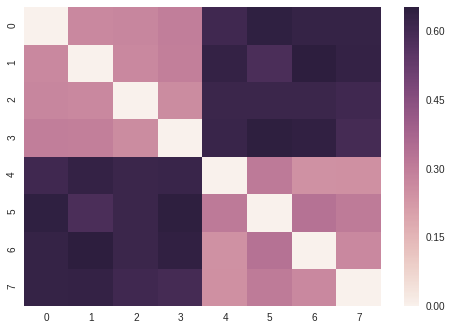

V2
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  5.37204689e-17   2.36223934e-01   2.38034520e-01   2.57882300e-01
    5.24065818e-01   5.69507005e-01   5.48388731e-01   5.54990329e-01]
 [  2.36223934e-01   5.37204689e-17   2.48272577e-01   2.53724133e-01
    5.56492952e-01   5.28940631e-01   5.73923248e-01   5.60948991e-01]
 [  2.38034520e-01   2.48272577e-01   2.86509168e-17   2.21205476e-01
    5.36176279e-01   5.52

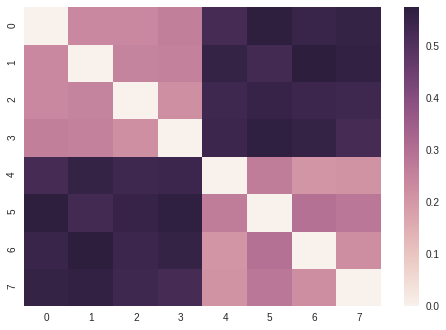

LOC
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  3.22322814e-17   1.80531481e-01   1.55998170e-01   1.76170011e-01
    4.04909519e-01   4.45296410e-01   4.17260340e-01   4.27752520e-01]
 [  1.80531481e-01   3.58136460e-17   1.81675084e-01   1.62875812e-01
    4.39118427e-01   4.43203061e-01   4.50862549e-01   4.45903686e-01]
 [  1.55998170e-01   1.81675084e-01   2.50695522e-17   1.57313617e-01
    4.10120204e-01   4.3

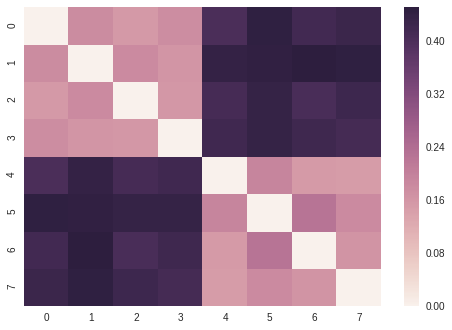

IT
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  2.50695522e-17   3.35824339e-01   3.19716971e-01   3.42065882e-01
    7.75759275e-01   7.80880983e-01   7.73296905e-01   7.87812625e-01]
 [  3.35824339e-01   4.65577397e-17   3.23339957e-01   3.31673026e-01
    7.84795941e-01   7.87717834e-01   7.92938616e-01   7.96407193e-01]
 [  3.19716971e-01   3.23339957e-01   6.08831981e-17   3.10868731e-01
    7.59183290e-01   7.76

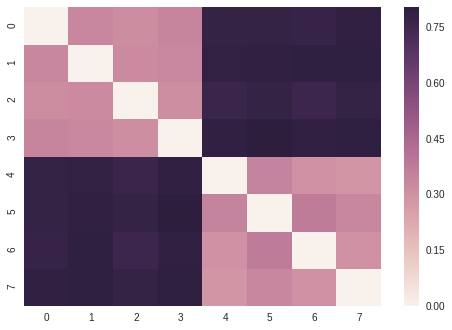

fusiform
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  2.50695522e-17   2.50785863e-01   2.63165149e-01   2.76692200e-01
    5.72348491e-01   5.95677127e-01   5.92270550e-01   6.01367194e-01]
 [  2.50785863e-01   3.58136460e-17   2.65745502e-01   2.69087836e-01
    6.21848423e-01   6.23255542e-01   6.47985887e-01   6.45815149e-01]
 [  2.63165149e-01   2.65745502e-01   4.29763751e-17   2.23457624e-01
    6.06120632e-01 

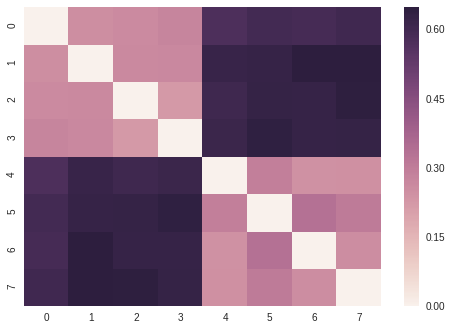

parahippo
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  3.93950106e-17   4.37926639e-01   4.62744532e-01   4.52932106e-01
    9.08920800e-01   9.34177038e-01   9.00983911e-01   8.94694644e-01]
 [  4.37926639e-01   3.22322814e-17   4.63470831e-01   4.58295580e-01
    9.48702704e-01   9.55433622e-01   9.49067470e-01   9.30550801e-01]
 [  4.62744532e-01   4.63470831e-01   3.22322814e-17   3.95249234e-01
    9.41189137e-01

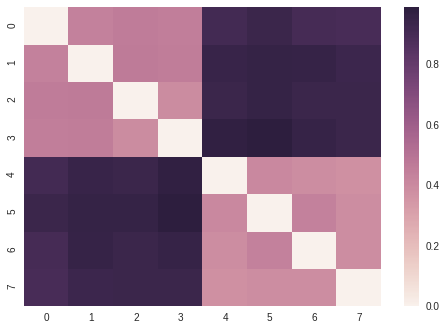

PRC
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  5.37204689e-17   4.46630429e-01   4.41124472e-01   4.47508836e-01
    9.64728306e-01   9.63052444e-01   9.45912249e-01   9.33587050e-01]
 [  4.46630429e-01   1.43254584e-17   4.41968954e-01   4.52263891e-01
    9.77523185e-01   9.71461684e-01   9.71712086e-01   9.65029655e-01]
 [  4.41124472e-01   4.41968954e-01   4.65577397e-17   4.10204524e-01
    9.74739281e-01   9.7

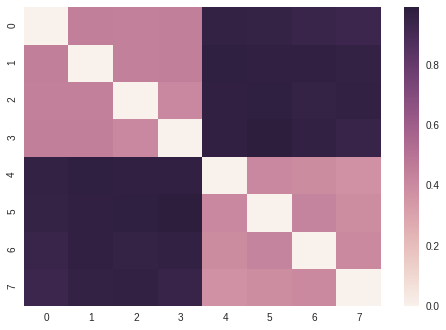

ento
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  3.93950106e-17   4.39426924e-01   4.40653748e-01   4.40695123e-01
    1.01598304e+00   9.88613974e-01   9.81002246e-01   9.82400382e-01]
 [  4.39426924e-01   5.01391043e-17   4.44201053e-01   4.21752036e-01
    9.95247691e-01   9.80332298e-01   9.94577951e-01   9.93795686e-01]
 [  4.40653748e-01   4.44201053e-01   3.58136460e-17   4.46538337e-01
    1.01236078e+00   9.

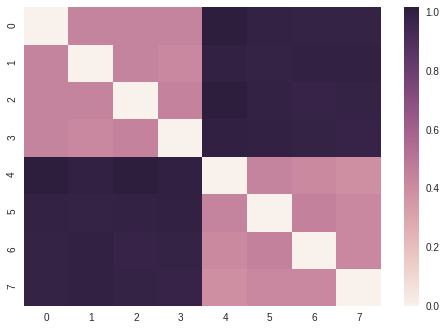

hipp
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  3.22322814e-17   4.33022497e-01   4.37703764e-01   4.74483042e-01
    9.23622817e-01   9.33510873e-01   9.53367461e-01   9.07672092e-01]
 [  4.33022497e-01   5.37204689e-17   4.55614160e-01   4.47735349e-01
    9.69974892e-01   9.54629109e-01   1.00648176e+00   9.56137632e-01]
 [  4.37703764e-01   4.55614160e-01   2.14881876e-17   4.20371352e-01
    9.27290070e-01   9.

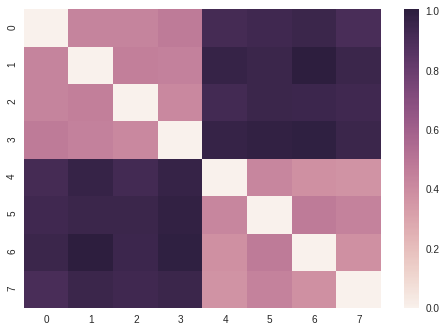

mOFC
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  3.22322814e-17   4.12605632e-01   4.05707022e-01   4.11467569e-01
    9.37779647e-01   9.88035702e-01   9.45094579e-01   9.63855973e-01]
 [  4.12605632e-01   3.93950106e-17   4.05568498e-01   3.82159761e-01
    9.33797678e-01   9.66707467e-01   9.41308410e-01   9.37355123e-01]
 [  4.05707022e-01   4.05568498e-01   2.86509168e-17   4.05291843e-01
    8.91109149e-01   9.

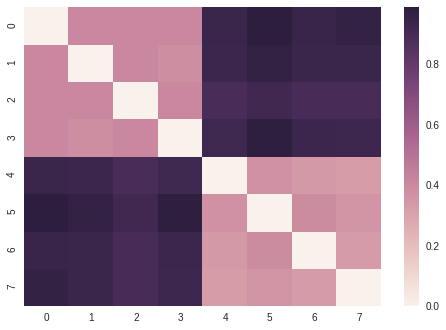

IFG
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  3.58136460e-17   3.61163675e-01   3.45223220e-01   3.79640068e-01
    8.20961419e-01   8.43568274e-01   8.30788880e-01   8.50669541e-01]
 [  3.61163675e-01   4.65577397e-17   3.54589411e-01   3.60275506e-01
    8.54908579e-01   8.80165097e-01   8.88068087e-01   8.78685146e-01]
 [  3.45223220e-01   3.54589411e-01   3.58136460e-17   3.37717495e-01
    8.14526761e-01   8.5

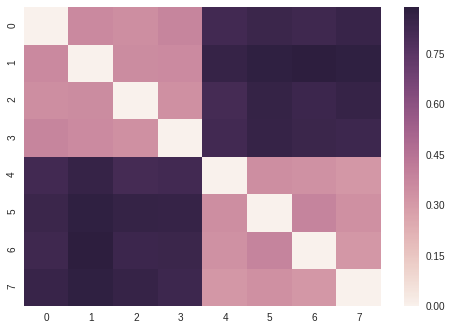

rostMFG
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  5.73018335e-17   3.48754466e-01   3.30870404e-01   3.63872925e-01
    7.78477144e-01   8.26425369e-01   7.96064434e-01   7.96608483e-01]
 [  3.48754466e-01   1.79068230e-17   3.52166780e-01   3.51186353e-01
    8.27039382e-01   8.27826720e-01   8.45336536e-01   8.40218184e-01]
 [  3.30870404e-01   3.52166780e-01   4.65577397e-17   3.20268819e-01
    7.51370107e-01  

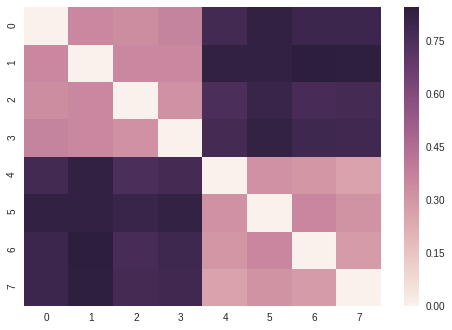

caudMFG
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  3.22322814e-17   3.77840218e-01   3.87296984e-01   4.01020615e-01
    7.23796590e-01   7.77509821e-01   7.68438589e-01   7.57328254e-01]
 [  3.77840218e-01   7.16272919e-17   3.77966245e-01   3.77747858e-01
    8.02095911e-01   8.20678297e-01   8.71847634e-01   8.38913118e-01]
 [  3.87296984e-01   3.77966245e-01   4.65577397e-17   3.09995541e-01
    7.22835006e-01  

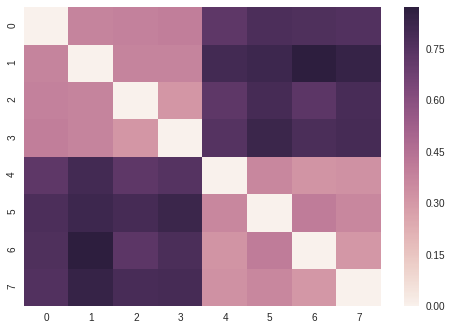

precentral
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  2.50695522e-17   3.09771124e-01   2.99888140e-01   3.21145830e-01
    6.80988792e-01   6.83917749e-01   6.80097521e-01   6.81353517e-01]
 [  3.09771124e-01   2.14881876e-17   2.91868777e-01   2.92648490e-01
    6.92655298e-01   6.92946556e-01   7.14597938e-01   7.04390753e-01]
 [  2.99888140e-01   2.91868777e-01   1.07440938e-17   2.62430890e-01
    6.53046568e-0

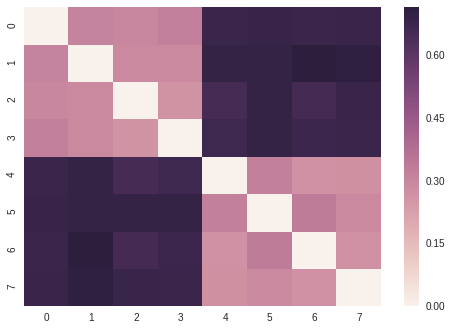

SMG
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  5.01391043e-17   3.15693410e-01   3.00339611e-01   3.18872403e-01
    7.60406526e-01   7.62862215e-01   7.27924542e-01   7.38185179e-01]
 [  3.15693410e-01   4.29763751e-17   3.06740076e-01   2.94895885e-01
    7.53776679e-01   7.32312527e-01   7.36919755e-01   7.20239219e-01]
 [  3.00339611e-01   3.06740076e-01   3.93950106e-17   3.07552662e-01
    7.39184518e-01   7.3

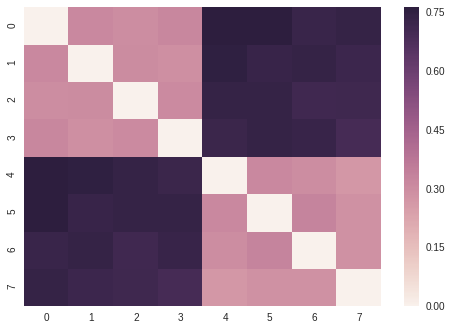

STG
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  4.29763751e-17   3.90165277e-01   3.74051450e-01   3.96591924e-01
    8.76234424e-01   8.94021449e-01   8.85861696e-01   8.82420294e-01]
 [  3.90165277e-01   2.14881876e-17   3.77690730e-01   3.78052348e-01
    8.96254931e-01   9.01948939e-01   9.19790188e-01   8.90326612e-01]
 [  3.74051450e-01   3.77690730e-01   2.86509168e-17   3.68244941e-01
    8.64787124e-01   8.8

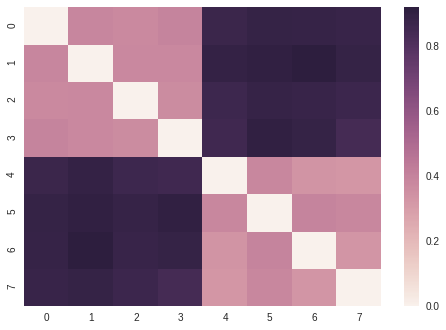

post
V1
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  5.73018335e-17   2.51769935e-01   2.38794045e-01   2.49483084e-01
    6.52066988e-01   6.75092782e-01   7.13765689e-01   6.60834884e-01]
 [  2.51769935e-01   3.93950106e-17   2.62196976e-01   2.66341054e-01
    6.55397945e-01   6.65013681e-01   7.15038260e-01   6.49292421e-01]
 [  2.38794045e-01   2.62196976e-01   3.22322814e-17   2.54874891e-01
    6.33324480e-01  

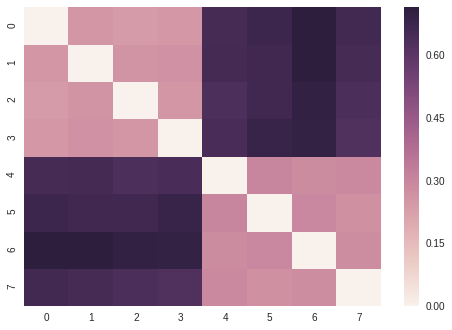

V2
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  3.93950106e-17   2.00972971e-01   1.91283979e-01   2.07887617e-01
    5.40680988e-01   5.54600686e-01   5.79626837e-01   5.54578289e-01]
 [  2.00972971e-01   1.43254584e-17   2.09200089e-01   2.17494154e-01
    5.42945466e-01   5.48707320e-01   5.89935017e-01   5.45471768e-01]
 [  1.91283979e-01   2.09200089e-01   3.58136460e-17   2.11049729e-01
    5.31390869e-01   5.50

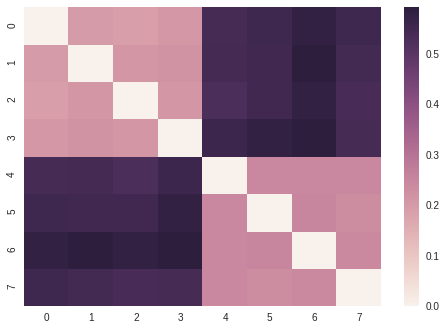

LOC
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  2.86509168e-17   1.28455398e-01   1.17562671e-01   1.28414927e-01
    4.08348739e-01   4.03063959e-01   4.15255445e-01   4.01921227e-01]
 [  1.28455398e-01   4.65577397e-17   1.27329032e-01   1.39057526e-01
    4.13158793e-01   4.01532547e-01   4.20510841e-01   3.99672963e-01]
 [  1.17562671e-01   1.27329032e-01   2.86509168e-17   1.34585597e-01
    4.07802663e-01   3.9

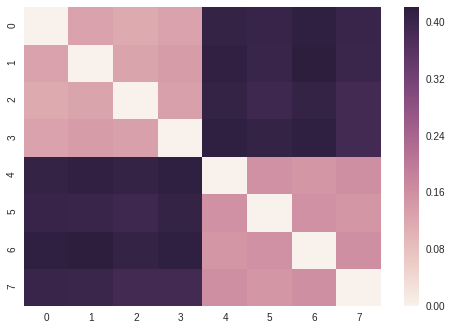

IT
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  3.22322814e-17   2.92137566e-01   2.84919869e-01   2.93700672e-01
    7.74103317e-01   7.56276247e-01   7.64931275e-01   7.95835516e-01]
 [  2.92137566e-01   5.01391043e-17   2.98549586e-01   3.13093590e-01
    7.60089253e-01   7.51754358e-01   7.54699942e-01   7.73060261e-01]
 [  2.84919869e-01   2.98549586e-01   3.58136460e-17   3.02536786e-01
    7.67636053e-01   7.49

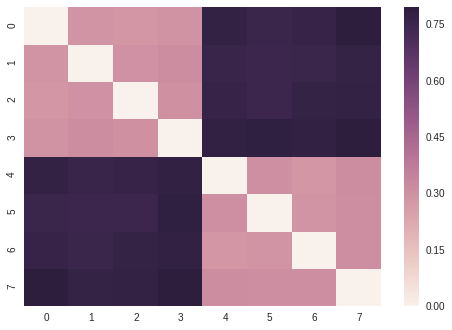

fusiform
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  3.22322814e-17   1.93367621e-01   1.87338100e-01   1.96699932e-01
    5.56860668e-01   5.43528958e-01   5.61467110e-01   5.63557475e-01]
 [  1.93367621e-01   4.29763751e-17   1.99854503e-01   2.13701553e-01
    5.55346758e-01   5.48662741e-01   5.60950016e-01   5.58815291e-01]
 [  1.87338100e-01   1.99854503e-01   5.01391043e-17   2.05085891e-01
    5.50476836e-01 

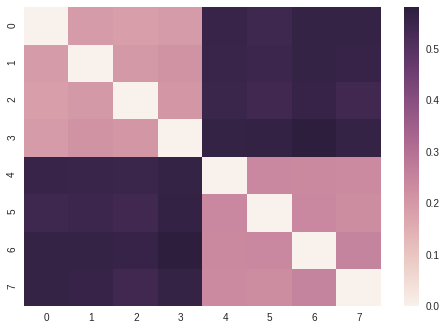

parahippo
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  5.01391043e-17   4.17674102e-01   4.06081804e-01   4.51253320e-01
    9.03497535e-01   8.41777102e-01   8.92767453e-01   8.92567962e-01]
 [  4.17674102e-01   5.73018335e-17   4.14877325e-01   4.50896311e-01
    9.11147876e-01   8.79627056e-01   9.11221838e-01   9.03857000e-01]
 [  4.06081804e-01   4.14877325e-01   2.50695522e-17   4.27793445e-01
    9.05478613e-01

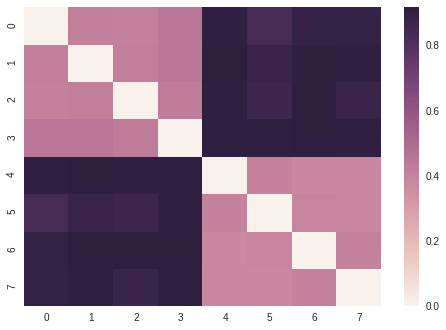

PRC
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  3.58136460e-17   4.15356119e-01   4.08886743e-01   4.24348060e-01
    9.35244087e-01   8.95726638e-01   9.33749401e-01   9.39206344e-01]
 [  4.15356119e-01   6.80459273e-17   4.12114704e-01   4.31657173e-01
    9.34559304e-01   9.10948089e-01   9.25242375e-01   9.28612515e-01]
 [  4.08886743e-01   4.12114704e-01   3.22322814e-17   4.36260301e-01
    9.47243364e-01   9.1

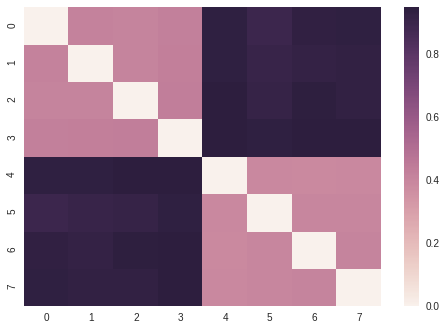

ento
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  3.58136460e-17   4.35278956e-01   4.23590839e-01   4.40800956e-01
    9.50263460e-01   9.38749741e-01   1.00442000e+00   9.68274891e-01]
 [  4.35278956e-01   1.07440938e-17   4.37556035e-01   4.52336870e-01
    9.47836462e-01   9.48659776e-01   9.81714094e-01   9.55859639e-01]
 [  4.23590839e-01   4.37556035e-01   3.93950106e-17   4.54466172e-01
    9.33738286e-01   9.

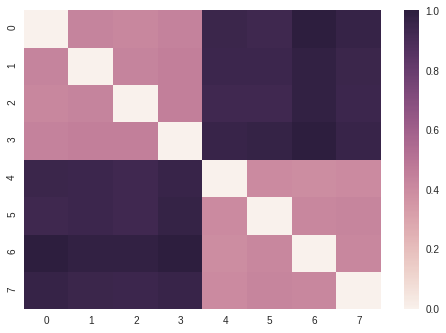

hipp
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  2.86509168e-17   4.40418007e-01   4.19199246e-01   4.18962188e-01
    9.44675881e-01   9.36723434e-01   9.37097401e-01   9.71723348e-01]
 [  4.40418007e-01   6.08831981e-17   4.47824270e-01   4.20536033e-01
    9.32810001e-01   9.64534165e-01   9.36858917e-01   9.59932647e-01]
 [  4.19199246e-01   4.47824270e-01   4.65577397e-17   4.17634846e-01
    9.24719069e-01   9.

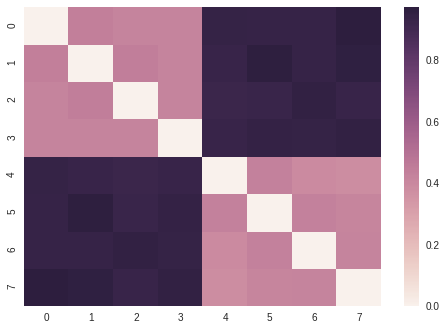

mOFC
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  1.07440938e-17   3.51495350e-01   3.46830158e-01   3.62076654e-01
    9.12661227e-01   8.94523471e-01   9.11109109e-01   9.19835828e-01]
 [  3.51495350e-01   5.37204689e-17   3.54145573e-01   3.74447995e-01
    8.96336626e-01   9.05280027e-01   9.15525243e-01   9.00207331e-01]
 [  3.46830158e-01   3.54145573e-01   4.29763751e-17   3.53433329e-01
    9.23455752e-01   9.

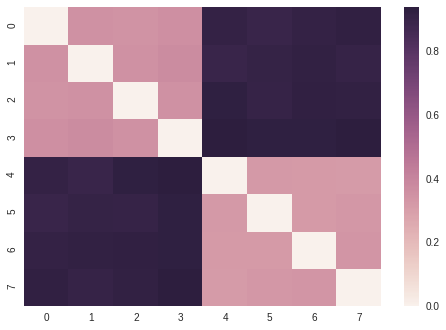

IFG
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  5.37204689e-17   3.27152075e-01   3.23584681e-01   3.43583530e-01
    8.50646785e-01   8.33642390e-01   8.33879884e-01   8.39165527e-01]
 [  3.27152075e-01   2.50695522e-17   3.49920215e-01   3.53854324e-01
    8.41667994e-01   8.26653675e-01   8.34361130e-01   8.45423837e-01]
 [  3.23584681e-01   3.49920215e-01   1.07440938e-17   3.39975888e-01
    8.29438623e-01   8.1

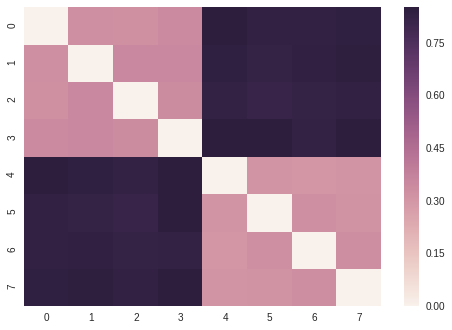

rostMFG
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  3.58136460e-17   2.98556581e-01   2.92335215e-01   3.01848360e-01
    8.15490887e-01   7.93732228e-01   8.03090557e-01   8.08797093e-01]
 [  2.98556581e-01   2.86509168e-17   3.14883904e-01   3.09229506e-01
    7.86289643e-01   7.86339699e-01   7.85974083e-01   8.01854518e-01]
 [  2.92335215e-01   3.14883904e-01   2.14881876e-17   3.04724743e-01
    8.16312593e-01  

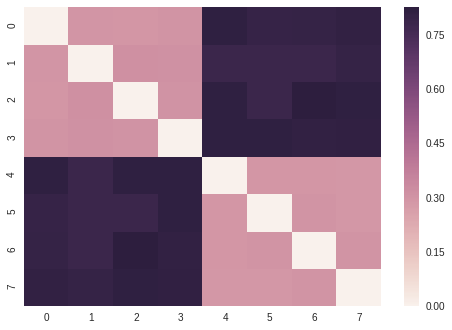

caudMFG
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  3.58136460e-17   3.32323933e-01   3.03232676e-01   3.20860064e-01
    7.80449170e-01   7.38286148e-01   7.56711842e-01   7.69112341e-01]
 [  3.32323933e-01   2.86509168e-17   3.12523567e-01   3.12879091e-01
    7.25324518e-01   7.04887471e-01   7.15332946e-01   7.38900928e-01]
 [  3.03232676e-01   3.12523567e-01   3.93950106e-17   3.17199220e-01
    7.78207842e-01  

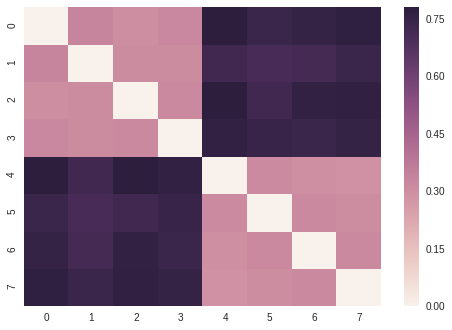

precentral
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  3.93950106e-17   2.37033197e-01   2.25165833e-01   2.27544964e-01
    6.45957613e-01   6.37958457e-01   6.54437415e-01   6.41408137e-01]
 [  2.37033197e-01   5.73018335e-17   2.43399135e-01   2.40779014e-01
    6.59064854e-01   6.70856571e-01   6.68217996e-01   6.46239586e-01]
 [  2.25165833e-01   2.43399135e-01   4.29763751e-17   2.33123008e-01
    6.50988902e-0

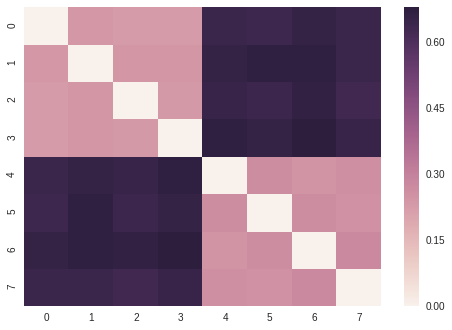

SMG
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  2.50695522e-17   2.96348654e-01   2.81194271e-01   2.97491438e-01
    7.32647917e-01   7.38533684e-01   7.57333149e-01   7.45455243e-01]
 [  2.96348654e-01   3.93950106e-17   2.86338497e-01   3.11991086e-01
    7.51181317e-01   7.26990347e-01   7.52878848e-01   7.33387088e-01]
 [  2.81194271e-01   2.86338497e-01   3.58136460e-17   2.85578713e-01
    7.15010956e-01   7.0

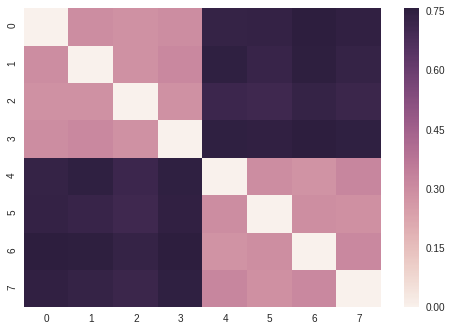

STG
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  3.93950106e-17   3.67754693e-01   3.53864468e-01   3.77069928e-01
    8.77263563e-01   8.76509570e-01   9.04644869e-01   8.94739823e-01]
 [  3.67754693e-01   2.86509168e-17   3.65823071e-01   3.81967224e-01
    8.78604394e-01   8.79356837e-01   9.12495873e-01   8.89430268e-01]
 [  3.53864468e-01   3.65823071e-01   2.86509168e-17   3.71810963e-01
    8.58930464e-01   8.5

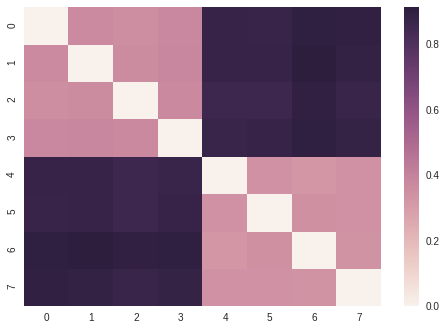

35
V1
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  2.50695522e-17   2.71169036e-01   2.75411641e-01   3.00415129e-01
    6.25839918e-01   6.22427325e-01   6.45400518e-01   6.66055385e-01]
 [  2.71169036e-01   2.86509168e-17   2.71568465e-01   2.93929871e-01
    6.81947966e-01   6.46650372e-01   6.76903824e-01   6.92135892e-01]
 [  2.75411641e-01   2.71568465e-01   5.37204689e-17   2.61483829e-01
    6.93671607e-01   6

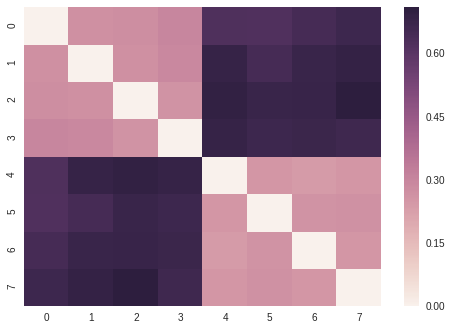

V2
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  5.37204689e-17   2.36223934e-01   2.38034520e-01   2.57882300e-01
    5.39435134e-01   5.31794882e-01   5.51379737e-01   5.72859775e-01]
 [  2.36223934e-01   5.37204689e-17   2.48272577e-01   2.53724133e-01
    5.77917926e-01   5.44678483e-01   5.76046982e-01   5.99060893e-01]
 [  2.38034520e-01   2.48272577e-01   2.86509168e-17   2.21205476e-01
    5.81162851e-01   5.64

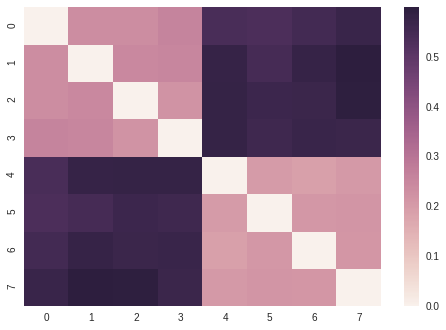

LOC
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  3.22322814e-17   1.80531481e-01   1.55998170e-01   1.76170011e-01
    3.91077489e-01   4.04133955e-01   3.97462568e-01   4.16064761e-01]
 [  1.80531481e-01   3.58136460e-17   1.81675084e-01   1.62875812e-01
    4.28756461e-01   4.22440331e-01   4.11705735e-01   4.41073091e-01]
 [  1.55998170e-01   1.81675084e-01   2.50695522e-17   1.57313617e-01
    4.07854236e-01   4.0

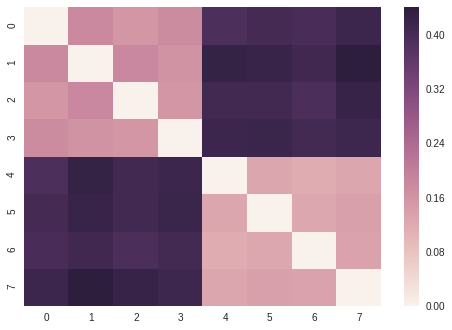

IT
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  2.50695522e-17   3.35824339e-01   3.19716971e-01   3.42065882e-01
    7.41229743e-01   7.63375201e-01   7.77507629e-01   7.80161749e-01]
 [  3.35824339e-01   4.65577397e-17   3.23339957e-01   3.31673026e-01
    7.67069546e-01   7.68550216e-01   7.79453422e-01   7.86485385e-01]
 [  3.19716971e-01   3.23339957e-01   6.08831981e-17   3.10868731e-01
    7.52985144e-01   7.72

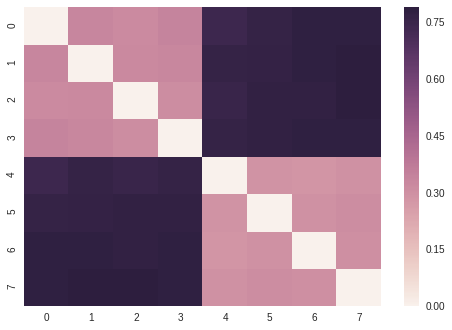

fusiform
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  2.50695522e-17   2.50785863e-01   2.63165149e-01   2.76692200e-01
    5.60553409e-01   5.84255346e-01   5.79128409e-01   5.83556603e-01]
 [  2.50785863e-01   3.58136460e-17   2.65745502e-01   2.69087836e-01
    5.82191571e-01   5.91788614e-01   5.84681288e-01   5.98732783e-01]
 [  2.63165149e-01   2.65745502e-01   4.29763751e-17   2.23457624e-01
    5.85707618e-01 

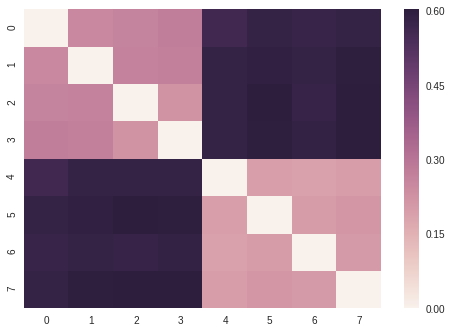

parahippo
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  3.93950106e-17   4.37926639e-01   4.62744532e-01   4.52932106e-01
    9.79185522e-01   9.62457231e-01   9.90751636e-01   9.85511632e-01]
 [  4.37926639e-01   3.22322814e-17   4.63470831e-01   4.58295580e-01
    9.72400989e-01   9.65015526e-01   9.64230544e-01   9.65281826e-01]
 [  4.62744532e-01   4.63470831e-01   3.22322814e-17   3.95249234e-01
    9.88736446e-01

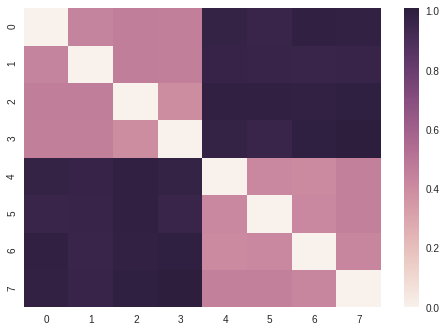

PRC
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  5.37204689e-17   4.46630429e-01   4.41124472e-01   4.47508836e-01
    9.72571062e-01   9.82986631e-01   9.82897163e-01   9.76990349e-01]
 [  4.46630429e-01   1.43254584e-17   4.41968954e-01   4.52263891e-01
    9.56012751e-01   9.61663544e-01   9.63065718e-01   9.47167715e-01]
 [  4.41124472e-01   4.41968954e-01   4.65577397e-17   4.10204524e-01
    9.95591324e-01   1.0

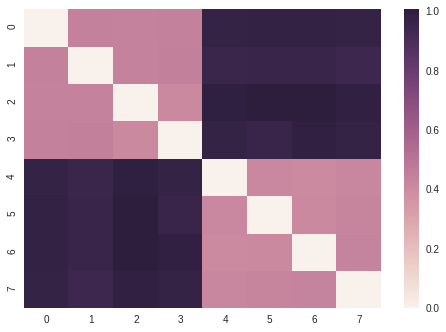

ento
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  3.93950106e-17   4.39426924e-01   4.40653748e-01   4.40695123e-01
    9.85753394e-01   9.77312301e-01   9.83801988e-01   9.78833355e-01]
 [  4.39426924e-01   5.01391043e-17   4.44201053e-01   4.21752036e-01
    9.85871486e-01   9.74503845e-01   9.83714789e-01   9.72130370e-01]
 [  4.40653748e-01   4.44201053e-01   3.58136460e-17   4.46538337e-01
    9.94406506e-01   9.

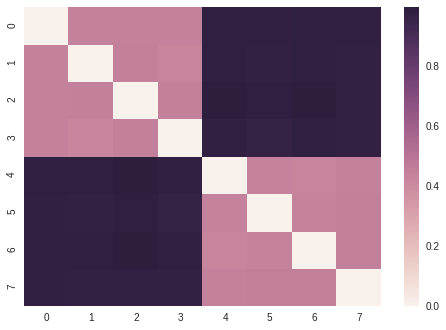

hipp
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  3.22322814e-17   4.33022497e-01   4.37703764e-01   4.74483042e-01
    9.81882643e-01   9.95831677e-01   9.78753080e-01   9.92281021e-01]
 [  4.33022497e-01   5.37204689e-17   4.55614160e-01   4.47735349e-01
    9.72515568e-01   9.82712739e-01   9.70936306e-01   9.74403494e-01]
 [  4.37703764e-01   4.55614160e-01   2.14881876e-17   4.20371352e-01
    1.01533614e+00   1.

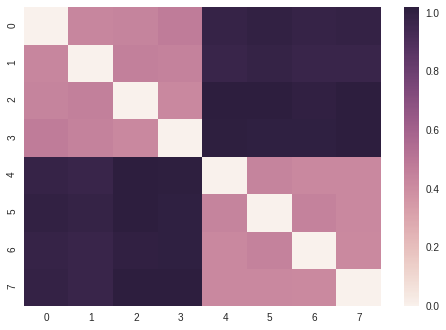

mOFC
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  3.22322814e-17   4.12605632e-01   4.05707022e-01   4.11467569e-01
    9.50764547e-01   9.38189909e-01   9.59260918e-01   9.27154346e-01]
 [  4.12605632e-01   3.93950106e-17   4.05568498e-01   3.82159761e-01
    9.16643646e-01   9.24186457e-01   9.51604307e-01   9.08044784e-01]
 [  4.05707022e-01   4.05568498e-01   2.86509168e-17   4.05291843e-01
    9.32198589e-01   9.

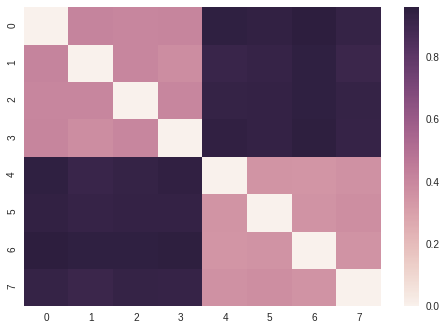

IFG
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  3.58136460e-17   3.61163675e-01   3.45223220e-01   3.79640068e-01
    8.46731379e-01   8.71204732e-01   8.62434410e-01   8.57506108e-01]
 [  3.61163675e-01   4.65577397e-17   3.54589411e-01   3.60275506e-01
    8.31130536e-01   8.59984906e-01   8.55134453e-01   8.52563686e-01]
 [  3.45223220e-01   3.54589411e-01   3.58136460e-17   3.37717495e-01
    8.45306863e-01   8.7

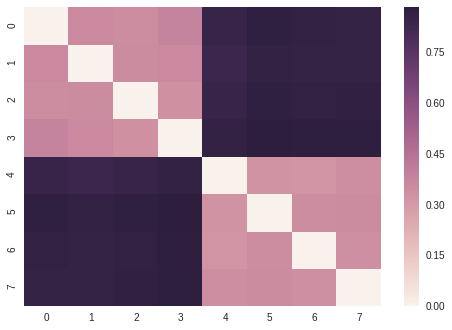

rostMFG
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  5.73018335e-17   3.48754466e-01   3.30870404e-01   3.63872925e-01
    8.42363381e-01   8.44266452e-01   8.47185043e-01   8.26407231e-01]
 [  3.48754466e-01   1.79068230e-17   3.52166780e-01   3.51186353e-01
    8.25666167e-01   8.31522806e-01   8.34365732e-01   8.25499145e-01]
 [  3.30870404e-01   3.52166780e-01   4.65577397e-17   3.20268819e-01
    8.38045752e-01  

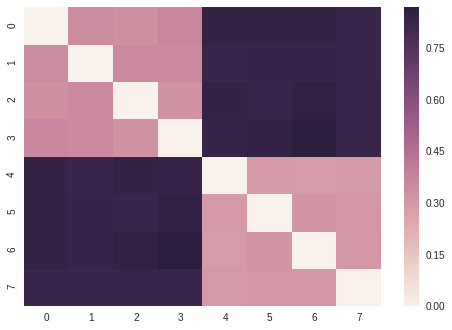

caudMFG
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  3.22322814e-17   3.77840218e-01   3.87296984e-01   4.01020615e-01
    7.47843181e-01   7.76715046e-01   8.07723375e-01   7.72880648e-01]
 [  3.77840218e-01   7.16272919e-17   3.77966245e-01   3.77747858e-01
    7.55770919e-01   7.78824303e-01   7.92296501e-01   7.85535025e-01]
 [  3.87296984e-01   3.77966245e-01   4.65577397e-17   3.09995541e-01
    7.68934791e-01  

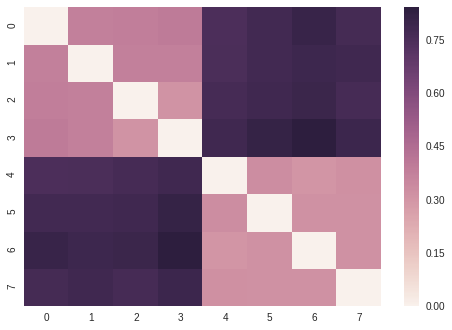

precentral
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  2.50695522e-17   3.09771124e-01   2.99888140e-01   3.21145830e-01
    6.46246753e-01   6.72608191e-01   6.61699782e-01   6.59431940e-01]
 [  3.09771124e-01   2.14881876e-17   2.91868777e-01   2.92648490e-01
    6.34432284e-01   6.44775921e-01   6.45749735e-01   6.50437678e-01]
 [  2.99888140e-01   2.91868777e-01   1.07440938e-17   2.62430890e-01
    6.61563148e-0

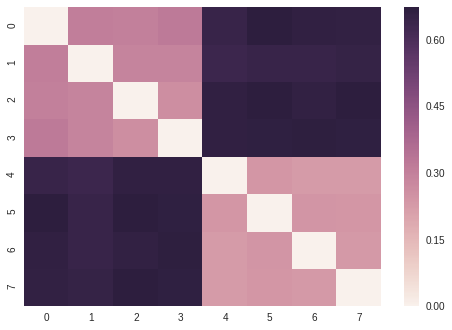

SMG
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  5.01391043e-17   3.15693410e-01   3.00339611e-01   3.18872403e-01
    7.04944912e-01   7.00128237e-01   7.01605753e-01   7.11987396e-01]
 [  3.15693410e-01   4.29763751e-17   3.06740076e-01   2.94895885e-01
    6.91911702e-01   7.01240832e-01   6.94997793e-01   6.92129073e-01]
 [  3.00339611e-01   3.06740076e-01   3.93950106e-17   3.07552662e-01
    7.07917786e-01   6.8

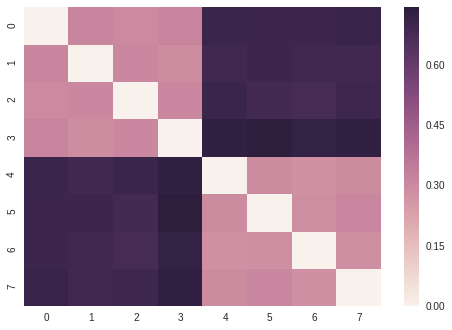

STG
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  4.29763751e-17   3.90165277e-01   3.74051450e-01   3.96591924e-01
    8.86898760e-01   9.01898188e-01   8.95914719e-01   8.75387538e-01]
 [  3.90165277e-01   2.14881876e-17   3.77690730e-01   3.78052348e-01
    8.79777514e-01   8.86302837e-01   8.91359205e-01   8.69583775e-01]
 [  3.74051450e-01   3.77690730e-01   2.86509168e-17   3.68244941e-01
    8.91394720e-01   8.9

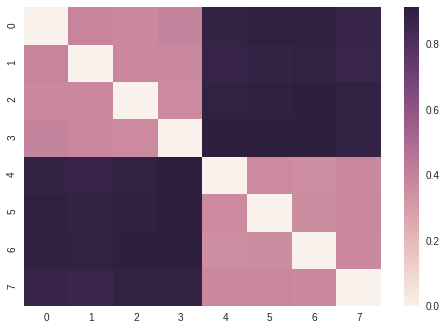

46
V1
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  3.58136460e-17   3.11892215e-01   2.46786648e-01   2.48956768e-01
    6.86134550e-01   7.35255644e-01   7.18033340e-01   7.20287837e-01]
 [  3.11892215e-01   5.01391043e-17   3.32421358e-01   3.08945712e-01
    6.96163407e-01   7.15697089e-01   7.20394928e-01   7.34996475e-01]
 [  2.46786648e-01   3.32421358e-01   3.93950106e-17   2.69324763e-01
    6.97229572e-01   7

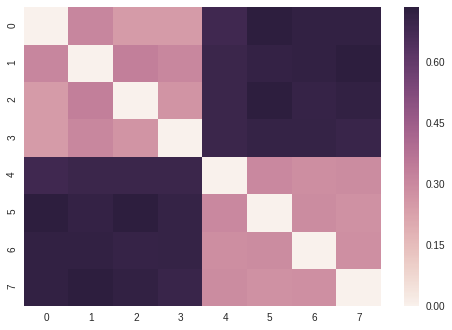

V2
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  2.50695522e-17   2.66705557e-01   2.06394189e-01   2.11298568e-01
    5.88583792e-01   6.18663207e-01   6.05471445e-01   6.02550631e-01]
 [  2.66705557e-01   3.93950106e-17   2.94683563e-01   2.79397507e-01
    6.07570547e-01   6.08202127e-01   6.15484476e-01   6.18452760e-01]
 [  2.06394189e-01   2.94683563e-01   1.79068230e-17   2.22326821e-01
    6.01327187e-01   6.23

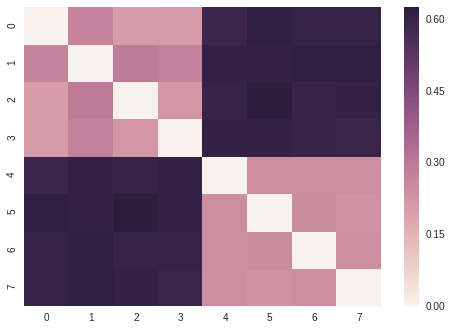

LOC
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  7.16272919e-18   1.92337845e-01   1.53374687e-01   1.48413994e-01
    4.88004501e-01   4.80047773e-01   4.99738021e-01   4.73049066e-01]
 [  1.92337845e-01   2.50695522e-17   2.27012959e-01   1.83070629e-01
    5.14265550e-01   4.82915504e-01   5.04492531e-01   4.82937219e-01]
 [  1.53374687e-01   2.27012959e-01   3.58136460e-17   1.63843580e-01
    4.98838270e-01   4.8

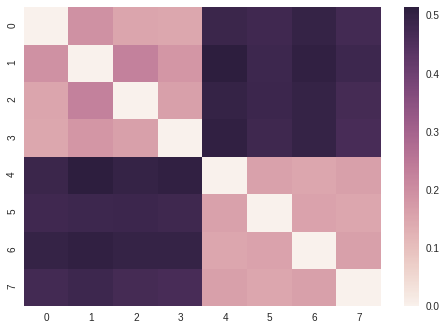

IT
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  3.58136460e-17   3.46042557e-01   2.99941451e-01   2.90318886e-01
    7.85370730e-01   7.85408164e-01   7.76202811e-01   7.81451056e-01]
 [  3.46042557e-01   4.29763751e-17   3.73321970e-01   3.36569847e-01
    7.80193367e-01   7.54762841e-01   7.61987555e-01   7.55919193e-01]
 [  2.99941451e-01   3.73321970e-01   3.58136460e-17   3.03501389e-01
    7.76022101e-01   7.89

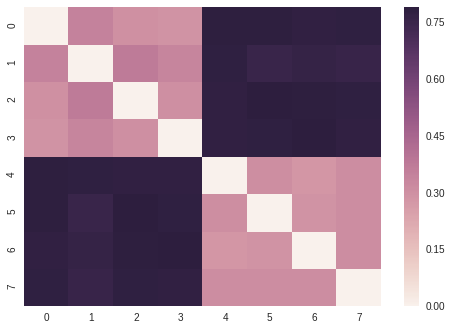

fusiform
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  3.58136460e-17   2.95654286e-01   2.42814566e-01   2.46901801e-01
    6.53469508e-01   6.44297341e-01   6.80788033e-01   6.48624906e-01]
 [  2.95654286e-01   5.73018335e-17   3.32385424e-01   3.08005224e-01
    6.80131828e-01   6.57687019e-01   6.87805789e-01   6.62468300e-01]
 [  2.42814566e-01   3.32385424e-01   3.93950106e-17   2.54921765e-01
    6.64580719e-01 

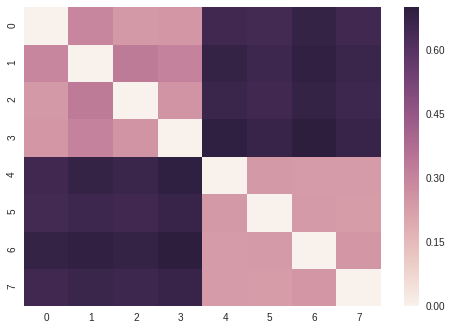

parahippo
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  3.58136460e-17   4.12325869e-01   3.87203358e-01   3.76958763e-01
    9.79726453e-01   9.72358123e-01   1.00920355e+00   1.00932880e+00]
 [  4.12325869e-01   2.14881876e-17   4.36093551e-01   3.88233148e-01
    1.01720228e+00   9.80522605e-01   1.04173557e+00   1.01416310e+00]
 [  3.87203358e-01   4.36093551e-01   2.14881876e-17   3.88884428e-01
    1.00526954e+00

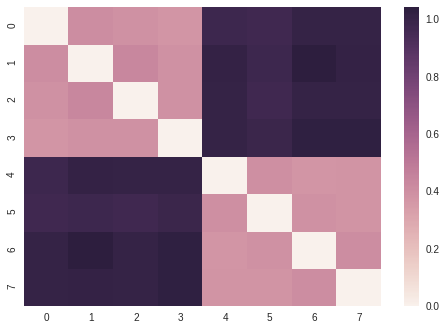

PRC
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  7.16272919e-17   4.09257797e-01   3.97309131e-01   3.71059719e-01
    9.82035246e-01   9.79482669e-01   9.89819683e-01   9.88789085e-01]
 [  4.09257797e-01   3.93950106e-17   4.32232041e-01   3.92660121e-01
    1.00237109e+00   1.00209336e+00   1.01647904e+00   1.02039772e+00]
 [  3.97309131e-01   4.32232041e-01   3.93950106e-17   4.04082819e-01
    9.76571940e-01   9.5

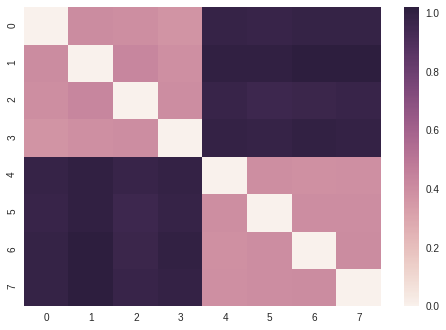

ento
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  3.22322814e-17   4.40396260e-01   4.15899396e-01   3.89387954e-01
    9.52357794e-01   9.60625244e-01   9.72323225e-01   9.63529871e-01]
 [  4.40396260e-01   5.01391043e-17   4.48655284e-01   4.16722032e-01
    9.54790411e-01   9.57148737e-01   9.69595439e-01   9.77564705e-01]
 [  4.15899396e-01   4.48655284e-01   4.29763751e-17   4.21704508e-01
    9.48222126e-01   9.

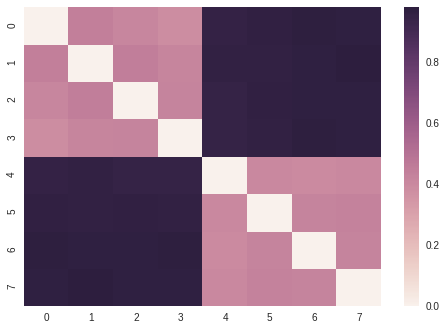

hipp
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  6.08831981e-17   4.24872556e-01   3.84891624e-01   3.72024934e-01
    9.64209994e-01   9.45872939e-01   9.37620052e-01   9.33962392e-01]
 [  4.24872556e-01   4.65577397e-17   4.76338311e-01   4.40774247e-01
    9.89422304e-01   9.39839747e-01   9.62446459e-01   9.59980975e-01]
 [  3.84891624e-01   4.76338311e-01   6.80459273e-17   3.81832118e-01
    1.01102590e+00   9.

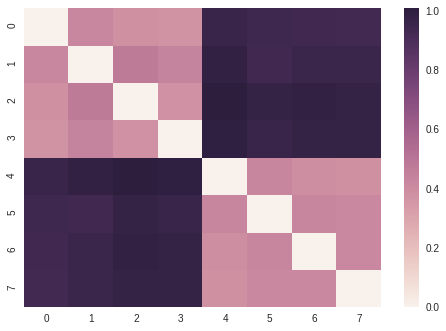

mOFC
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  6.08831981e-17   3.69681051e-01   3.42076718e-01   3.25984629e-01
    9.32858361e-01   9.17882112e-01   9.37172768e-01   9.17343278e-01]
 [  3.69681051e-01   2.86509168e-17   3.95369477e-01   3.61165833e-01
    9.03109639e-01   8.74680549e-01   9.01834663e-01   8.89661403e-01]
 [  3.42076718e-01   3.95369477e-01   5.37204689e-17   3.31527396e-01
    9.37467209e-01   9.

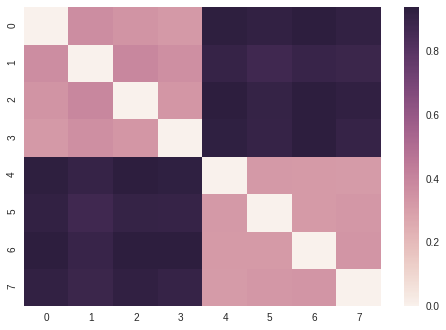

IFG
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  2.86509168e-17   3.45369915e-01   3.35300503e-01   3.09639829e-01
    8.58497224e-01   8.39013439e-01   8.43852282e-01   8.48193496e-01]
 [  3.45369915e-01   5.01391043e-17   3.87876009e-01   3.39908810e-01
    8.63307705e-01   8.46364828e-01   8.68176331e-01   8.58843887e-01]
 [  3.35300503e-01   3.87876009e-01   3.58136460e-17   3.11519762e-01
    8.58489522e-01   8.4

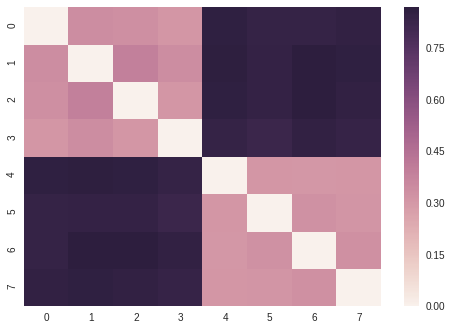

rostMFG
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  2.86509168e-17   3.14778658e-01   2.99565670e-01   2.58414753e-01
    8.12780162e-01   8.05970626e-01   7.79985099e-01   8.00780346e-01]
 [  3.14778658e-01   2.50695522e-17   3.55432759e-01   3.12527129e-01
    8.32841860e-01   7.92686042e-01   8.30811640e-01   8.23980418e-01]
 [  2.99565670e-01   3.55432759e-01   5.37204689e-17   2.82327894e-01
    8.20652717e-01  

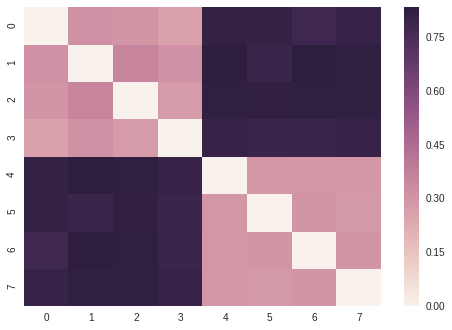

caudMFG
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  6.44645627e-17   3.66976749e-01   3.19612147e-01   3.24662996e-01
    8.10761639e-01   7.94325162e-01   7.92258485e-01   7.90811285e-01]
 [  3.66976749e-01   3.22322814e-17   4.07683196e-01   3.67668274e-01
    8.42912456e-01   7.80935921e-01   8.54829004e-01   8.29495349e-01]
 [  3.19612147e-01   4.07683196e-01   3.22322814e-17   3.04777376e-01
    8.40679171e-01  

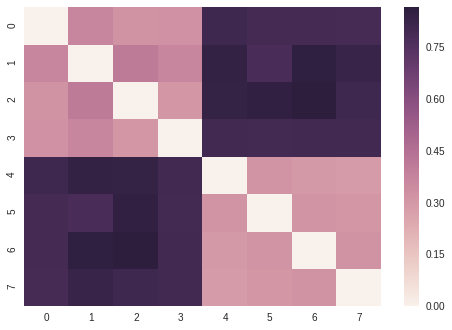

precentral
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  4.65577397e-17   3.19346913e-01   2.68152727e-01   2.71548532e-01
    7.15390718e-01   7.15802531e-01   7.15103545e-01   7.06207260e-01]
 [  3.19346913e-01   2.14881876e-17   3.32898897e-01   2.91038740e-01
    7.23382802e-01   7.24039552e-01   7.30803093e-01   7.10761216e-01]
 [  2.68152727e-01   3.32898897e-01   3.58136460e-17   2.65251891e-01
    7.12843602e-0

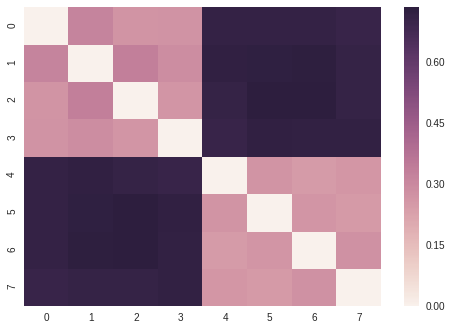

SMG
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  3.22322814e-17   3.14812065e-01   3.02364419e-01   2.68092050e-01
    7.24145222e-01   7.39908792e-01   7.33811254e-01   7.32759380e-01]
 [  3.14812065e-01   3.93950106e-17   3.31835616e-01   2.87029947e-01
    7.34761327e-01   7.54854930e-01   7.54149596e-01   7.51562553e-01]
 [  3.02364419e-01   3.31835616e-01   2.86509168e-17   2.85135264e-01
    7.19850068e-01   7.2

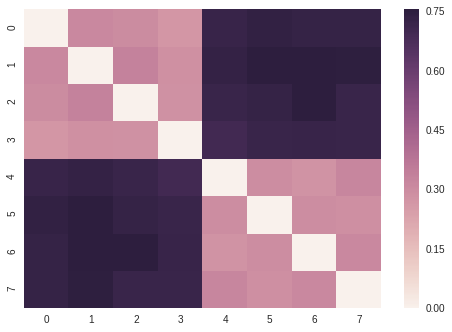

STG
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
[[  3.22322814e-17   3.84953205e-01   3.37533507e-01   3.23497291e-01
    8.52373075e-01   8.54546844e-01   8.53128432e-01   8.44250040e-01]
 [  3.84953205e-01   1.43254584e-17   4.02347854e-01   3.84826203e-01
    8.68392408e-01   8.39023400e-01   8.68963222e-01   8.59387410e-01]
 [  3.37533507e-01   4.02347854e-01   5.73018335e-17   3.31950628e-01
    8.74242412e-01   8.7

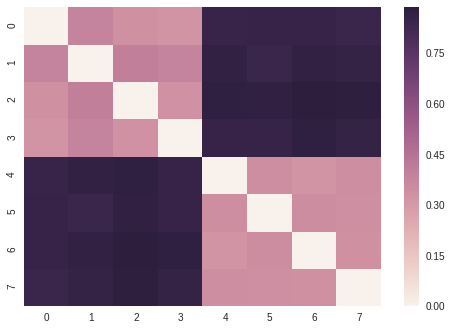

In [11]:
# for each phase and each ROI, produce a mean RDM across subjects based on RSA

ROIs = ["V1", "V2", "LOC", "IT", "fusiform", "parahippo",  "PRC",  "ento", "hipp", 'mOFC', 'IFG', 'rostMFG', 'caudMFG', 'precentral', 'SMG', 'STG']

def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    print(df)
    corr = pd.DataFrame(data=df)
    #fig, ax = plt.subplots(figsize=(size, size))
    #ax.matshow(corr)
    sns.heatmap(df, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
    #plt.xticks(range(len(corr.columns)), corr.columns);
    #plt.yticks(range(len(corr.columns)), corr.columns);

for phase in ['pre', 'post', '35', '46']:
    print(phase)
    
    for roi in ROIs:
        print(roi)
        
        rdms = []
        for s in sub_dirs:
            print(s)
            rdms.append(matrix(s,phase,roi))
        
        plot_corr(np.mean(np.array(rdms), axis=0))
        plt.savefig('/home/jgunn/neurosketch/rsa_figs/' + roi + '_' + phase + '.png')
        plt.show()

In [12]:
# average value of C for top right part of matrix for each ROI/phase?

ROIs_framed = pd.DataFrame(data=np.array(ROIs),)
pre = pd.DataFrame(data=[np.mean([np.mean(matrix(s,'pre',roi)[:4,range(4,8)]) for s in sub_dirs]) for roi in ROIs])
post = pd.DataFrame(data=[np.mean([np.mean(matrix(s,'post',roi)[:4,range(4,8)]) for s in sub_dirs]) for roi in ROIs])
spliceA = pd.DataFrame(data=[np.mean([np.mean(matrix(s,'35',roi)[:4,range(4,8)]) for s in sub_dirs]) for roi in ROIs])
spliceB = pd.DataFrame(data=[np.mean([np.mean(matrix(s,'46',roi)[:4,range(4,8)]) for s in sub_dirs]) for roi in ROIs])
df = pd.concat([ROIs_framed, pre, post, spliceA, spliceB], axis=1)
df.columns=['ROI', '34', '56', '35', '46']
df

,ROI,34,56,35,46
0,V1,0.624804,0.666953,0.669068,0.713223
1,V2,0.548185,0.557436,0.567523,0.606749
2,LOC,0.427567,0.405391,0.412439,0.489190
3,IT,0.782605,0.770748,0.771843,0.777166
4,fusiform,0.619332,0.557547,0.588080,0.668967
5,parahippo,0.940246,0.895767,0.980778,1.004053
6,PRC,0.966009,0.932675,0.977469,0.989959
7,ento,0.991023,0.962331,0.979762,0.961515
8,hipp,0.954762,0.943217,0.996050,0.970071
9,mOFC,0.936062,0.915172,0.936206,0.915523


In [13]:
# average absolute value?

ROIs_framed = pd.DataFrame(data=np.array(ROIs),)
pre = pd.DataFrame(data=[np.mean([np.mean(np.absolute(matrix(s,'pre',roi)[:4,range(4,8)])) for s in sub_dirs]) for roi in ROIs])
post = pd.DataFrame(data=[np.mean([np.mean(np.absolute(matrix(s,'post',roi)[:4,range(4,8)])) for s in sub_dirs]) for roi in ROIs])
spliceA = pd.DataFrame(data=[np.mean([np.mean(np.absolute(matrix(s,'35',roi)[:4,range(4,8)])) for s in sub_dirs]) for roi in ROIs])
spliceB = pd.DataFrame(data=[np.mean([np.mean(np.absolute(matrix(s,'46',roi)[:4,range(4,8)])) for s in sub_dirs]) for roi in ROIs])
df = pd.concat([ROIs_framed, pre, post, spliceA, spliceB], axis=1)
df.columns=['ROI', '34', '56', '35', '46']
df

,ROI,34,56,35,46
0,V1,0.624804,0.666953,0.669068,0.713223
1,V2,0.548185,0.557436,0.567523,0.606749
2,LOC,0.427567,0.405391,0.412439,0.489190
3,IT,0.782605,0.770748,0.771843,0.777166
4,fusiform,0.619332,0.557547,0.588080,0.668967
5,parahippo,0.940246,0.895767,0.980778,1.004053
6,PRC,0.966009,0.932675,0.977469,0.989959
7,ento,0.991023,0.962331,0.979762,0.961515
8,hipp,0.954762,0.943217,0.996050,0.970071
9,mOFC,0.936062,0.915172,0.936206,0.915523


In [ ]:
def cellwise_correlate(listA, listB):
    listA = [array.flatten() for array in listA]
    listB = [array.flatten() for array in listB]
    
    length = listA[0].size

## Similarity analysis

In [8]:
## DESIGN ## ## ## ## 
## There are four objects (bed, bench, chair, table). Participants viewed each object 20 times per run.
## Runs 1 & 2 -- reserved to conduct searchlight
## Runs 3 & 4 -- pretest phase 
## Four training runs involving practice drawing two of the trained objects. 
## Runs 5 & 6 -- posttest phase
## GOAL ## ## ## ## 
## Compare similarity between Trained object representations before and after training (vs. Control) in several
## anatomically-defined ROIs. To do this, define `representation' as cope maps generated 
## upon fitting GLM to each object for each run. Build object x voxel matrix (4xK) for each run, vertically concatenate
## the two runs in each phase, and compute correlation matrix. Consider M = off-diagonal 4x4 block [:4,4:8].
## Make sure the rows are sorted such that the first two are the Trained, and the last two are the Control objects.
## Now take the the top-left 2x2 matrix within M and let's call it M-trained. The bottom-right 2x2 = M-control.
## The diagonal elements of M-trained (A,D depicted below) reflect the representational similarity for the *same* object between runs.
## The off diagonal elements of M-trained (B,C) reflect the similarity between different objects across runs. 
## [_A_|_B_]
## [_C_|_D_]
## Mean of (B,C) - Mean(A,D) = Representational distance between objects in this phase. 
## Do the above for the pretest, then for the posttest, and compare.

In [9]:
## Example code block single subject and ROI (fusiform):
this_sub = sub_dirs[0]
run_example = 1
if run_example:
    trawit_mean_pre,conwit_mean_pre,trabtw_mean_pre,conbtw_mean_pre = compare_btw_wit_cond_similarity_across_runs(this_sub,'pre','fusiform')
    trawit_mean_post,conwit_mean_post,trabtw_mean_post,conbtw_mean_post = compare_btw_wit_cond_similarity_across_runs(this_sub,'post','fusiform')
    
    trawit_mean_on, conwit_mean_on, trabtw_mean_on, conbtw_mean_on = compare_btw_wit_cond_similarity_across_runs(this_sub,'35','fusiform')
    trawit_mean_off, conwit_mean_off, trabtw_mean_off, conbtw_mean_off = compare_btw_wit_cond_similarity_across_runs(this_sub,'46','fusiform')

    tradiff_pre = trabtw_mean_pre - trawit_mean_pre
    condiff_pre = conbtw_mean_pre - conwit_mean_pre

    tradiff_post = trabtw_mean_post - trawit_mean_post
    condiff_post = conbtw_mean_post - conwit_mean_post

    print('Trained Btw-Wit Post-Pre: ' + str(tradiff_post-tradiff_pre))
    print('Control Btw-Wit Post-Pre: ' + str(condiff_post-condiff_pre))  

#sklearn approach to measuring distance
#Trained Btw-Wit Post-Pre: 0.00486909558952
#Control Btw-Wit Post-Pre: -0.00358913246024

Trained Btw-Wit Post-Pre: 0.00486909558952
Control Btw-Wit Post-Pre: -0.00358913246024


In [19]:
### April 8 2017: Now compute for all subjects (N=33 at time of initial commit), and for 5 different anat-ROIs

Tradiffpre = []
Condiffpre = []
Tradiffpost = []
Condiffpost = []
Trained = []
Control = []

# ventemp = ventral temporal ROI = IT + parahippo + fusiform
# occipital = ventral temporal ROI = V1 + LOC
ROIs = ["V1", "V2", "LOC", "IT", "fusiform", "parahippo",  "PRC",  "ento", "hipp", 'mOFC', 'IFG', 'rostMFG', 'caudMFG', 'precentral', 'SMG', 'STG']
#ROIs = ['V1','fusiform','IT','LOC','occitemp','parahippo','ventemp', 'occipital']

for roi in ROIs:
    print(roi)    
    _Tradiffpre = []
    _Condiffpre = []
    _Tradiffpost = []
    _Condiffpost = []
    _Trained = []
    _Control = []
        
    for s in sub_dirs:
        print(s)
        trawit_mean_pre, conwit_mean_pre, trabtw_mean_pre, conbtw_mean_pre = \
        compare_btw_wit_cond_similarity_across_runs(s,'pre',roi)
        trawit_mean_post, conwit_mean_post, trabtw_mean_post, conbtw_mean_post = \
        compare_btw_wit_cond_similarity_across_runs(s,'post',roi)
        
        trawit_mean_on, conwit_mean_on, trabtw_mean_on, conbtw_mean_on = \
        compare_btw_wit_cond_similarity_across_runs(s,'35',roi)
        trawit_mean_off, conwit_mean_off, trabtw_mean_off, conbtw_mean_off = \
        compare_btw_wit_cond_similarity_across_runs(s,'46',roi)
        
        _Tradiffpre.append(trabtw_mean_pre - trawit_mean_pre)
        _Condiffpre.append(conbtw_mean_pre - conwit_mean_pre)
        
        _Tradiffpost.append(trabtw_mean_post - trawit_mean_post)
        _Condiffpost.append(conbtw_mean_post - conwit_mean_post)
    
        _Trained.append(np.mean([(trabtw_mean_on - trawit_mean_on), (trabtw_mean_off - trawit_mean_off)]) - (trabtw_mean_pre - trawit_mean_pre))
        _Control.append(np.mean([(conbtw_mean_on - conwit_mean_on), (conbtw_mean_off - conwit_mean_off)]) - (conbtw_mean_pre - conwit_mean_pre))
        
    _Tradiffpre,_Condiffpre, _Tradiffpost,_Condiffpost, _Trained, _Control = map(np.array, \
                                                               [_Tradiffpre,_Condiffpre,_Tradiffpost,_Condiffpost, _Trained, _Control])
        
    if len(Tradiffpre)==0:
        Tradiffpre = _Tradiffpre
        Condiffpre = _Condiffpre
        Tradiffpost = _Tradiffpost
        Condiffpost = _Condiffpost
        Trained = _Trained
        Control = _Control
    else:
        Tradiffpre = np.vstack((Tradiffpre,_Tradiffpre))
        Condiffpre = np.vstack((Condiffpre,_Condiffpre))
        Trained = np.vstack((Trained,_Trained))
        Control = np.vstack((Control,_Control))
        Tradiffpost = np.vstack((Tradiffpost,_Tradiffpost))
        Condiffpost = np.vstack((Condiffpost,_Condiffpost))

V1
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
V2
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neuros

In [15]:
import pandas as pd 

Tradifflearn = Tradiffpost-Tradiffpre
Condifflearn = Condiffpost-Condiffpre

labels = pd.DataFrame(data=sub_dirs, columns = ['IDs'])
MAT = np.hstack((Trained.transpose(),Control.transpose(), Tradifflearn.transpose(), Condifflearn.transpose()))

ROIS = ROIs
CONDS = ['trained', 'control', 'tradiff', 'condiff']
headers = []
for cond in CONDS:
    for roi in ROIS:
        headers.append('{}_{}'.format(cond,roi))
        
df = pd.DataFrame(data=MAT, columns = headers)
ids = pd.DataFrame(np.array(sub_dirs), columns = ['IDs'])
df = pd.concat([ids, df], axis = 1)
df.to_csv('neural_changes_by_surfroi_and_subject.csv')

In [16]:
df

,IDs,trained_V1,trained_V2,trained_LOC,trained_IT,trained_fusiform,trained_parahippo,trained_PRC,trained_ento,trained_hipp,...,condiff_PRC,condiff_ento,condiff_hipp,condiff_mOFC,condiff_IFG,condiff_rostMFG,condiff_caudMFG,condiff_precentral,condiff_SMG,condiff_STG
0,0110171_neurosketch,0.013969,0.026494,0.024232,0.002145,0.017853,-0.066191,-0.038201,0.026076,-0.056993,...,-0.034700,0.000027,-0.064084,-0.086041,-0.087247,-0.050124,-0.094722,-0.050321,-0.127886,-0.021643
1,0110172_neurosketch,-0.010256,-0.001220,0.024393,-0.045568,-0.019246,-0.008816,0.007859,0.026258,-0.007713,...,-0.030602,-0.017600,-0.115821,0.012603,0.003377,-0.029311,-0.017860,0.038456,0.041973,-0.032208
2,0111171_neurosketch,0.067659,0.037721,0.044253,0.078619,0.021371,-0.093432,-0.043942,-0.033467,0.000604,...,-0.005794,-0.050809,0.009089,0.059522,0.052912,0.100313,-0.011249,0.139831,0.036634,0.018697
3,0112171_neurosketch,-0.000842,0.002255,-0.034087,-0.052698,-0.055887,-0.012348,0.064003,0.103867,-0.082044,...,-0.015484,0.054129,-0.056987,-0.003193,0.016371,0.066079,0.065308,0.025893,-0.015257,-0.003792
4,0112172_neurosketch,0.015042,0.002949,0.002315,-0.000101,0.007230,0.003432,-0.033731,-0.010261,-0.021362,...,-0.029092,0.007124,0.039762,0.038220,-0.014906,-0.004139,-0.060099,0.036545,0.048539,0.034781
5,0112173_neurosketch,0.016728,-0.014799,-0.022754,-0.010832,0.001041,0.003862,-0.047914,-0.060520,-0.015561,...,0.008613,-0.026283,0.013174,-0.035848,-0.018553,-0.161208,-0.057309,-0.019952,-0.016303,-0.044347
6,0113171_neurosketch,0.005762,-0.005911,-0.007162,0.022326,-0.005748,0.035143,0.042849,-0.007469,0.008294,...,-0.063991,-0.033244,-0.026203,-0.039095,-0.086195,-0.035528,-0.112487,-0.033812,-0.060702,-0.048279
7,0115174_neurosketch,0.014234,0.045453,0.041849,0.081381,0.085553,0.133786,-0.000419,0.045129,0.059922,...,0.040500,0.021894,-0.018766,0.005516,-0.033779,-0.010066,-0.029297,-0.011240,-0.060136,-0.023882
8,0117171_neurosketch,-0.041654,-0.045521,-0.122641,-0.037504,-0.062908,0.021395,0.021778,-0.058576,0.009963,...,-0.015962,-0.003247,-0.006325,0.013531,-0.015062,-0.014544,0.008711,0.007410,0.045059,-0.020756
9,0118171_neurosketch,-0.030962,-0.025349,0.001432,-0.061912,-0.044282,0.014298,-0.040403,0.060134,-0.025999,...,-0.055666,-0.070177,-0.012665,-0.034128,-0.081167,-0.044214,-0.131684,-0.044560,-0.019516,-0.075094


In [12]:
## save out so you can import later and share
if shape(Tradiffpre)==(len(ROIs),len(sub_dirs)): ## ONLY save out if you've actually finished the analysis above
    with open("prepost_differentiation_by_condition_with_ventemp_occipital.pkl", 'wb')  as _f:
        cPickle.dump([Tradiffpost,Tradiffpre,Condiffpost,Condiffpre], _f)

In [13]:
# print('Trained Btw-Wit Post-Pre: ' + str(Tradiffpost-Tradiffpre))
# print('Control Btw-Wit Post-Pre: ' + str(Condiffpost-Condiffpre))  

In [14]:
## load in saved pkl
with open('prepost_differentiation_by_condition_with_ventemp_occipital.pkl', 'rb') as f:
    prepost_diff = cPickle.load(f, encoding='latin1') 

In [15]:
## save out as npy
np.save('prepost_differentiation_by_condition_with_ventemp_occipital.npy',prepost_diff)

### Sensitivity to measuring differences between object representations separately in each phase

In [33]:
## Make sure that the off-diagonal minus on-diagonal elements (btw-within) in each matrix > 0.
## this indicates that the correlation distance between different objects is larger than that between
## measurements of the same object. This needs to be the case for looking at learning to make sense. 


In [20]:
tmp = np.dstack((Tradiffpre,Condiffpre))
Diffpre = tmp.mean(2)

tmp = np.dstack((Tradiffpost,Condiffpost))
Diffpost = tmp.mean(2)

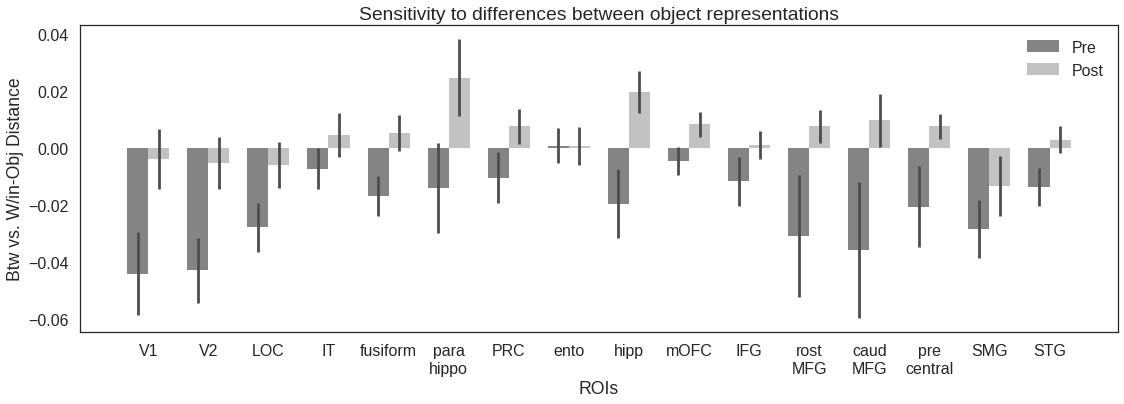

In [21]:
ROIs = ["V1", "V2", "LOC", "IT", "fusiform", "parahippo",  "PRC",  "ento", "hipp", 'mOFC', 'IFG', 'rostMFG', 'caudMFG', 'precentral', 'SMG', 'STG']
ROIs_formatted = ["V1", "V2", "LOC", "IT", "fusiform", "para\nhippo",  "PRC",  "ento", "hipp", 'mOFC', 'IFG', 'rost\nMFG', 'caud\nMFG', 'pre\ncentral', 'SMG', 'STG']

sns.set_style('white')
sns.set_context('poster')

means_pre = Diffpre.mean(1)
std_pre = Diffpre.std(1)/np.sqrt(shape(Diffpre)[1])

means_post = Diffpost.mean(1)
std_post = Diffpost.std(1)/np.sqrt(shape(Diffpost)[1])

fig, ax = plt.subplots(figsize=(len(ROIs),6))

n_groups = len(ROIs) # num ROIs
index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.8
error_config = {'ecolor': '0.3'}

## plot means as bars
tcolor = (0.4,0.4,0.4)
rects1 = plt.bar(index, means_pre, bar_width,
                 alpha=opacity,
                 color=(0.4,0.4,0.4),
                 yerr=std_pre,
                 error_kw=error_config,
                 label='Pre')

ccolor = (0.7,0.7,0.7)
rects2 = plt.bar(index + bar_width, means_post, bar_width,
                 alpha=opacity,
                 color=(0.7,0.7,0.7),
                 yerr=std_post,
                 error_kw=error_config,
                 label='Post')


plt.xlabel('ROIs')
plt.ylabel('Btw vs. W/in-Obj Distance')
plt.title('Sensitivity to differences between object representations')
plt.xticks(index + bar_width / 2, ROIs_formatted)
plt.legend()
plt.tight_layout()
plt.show()

### Learning-related changes in representational distance

Old Distance Measure

In [22]:
Tradifflearn = Tradiffpost-Tradiffpre
Condifflearn = Condiffpost-Condiffpre

In [23]:
# ROIs = ['V1','fusiform','IT','LOC','occitemp']
print(Tradifflearn.std(1)/np.sqrt(shape(Tradifflearn)[1]))
print(Condifflearn.mean(1))

[ 0.02919362  0.02293608  0.01347964  0.01232225  0.01289287  0.01634934
  0.01014596  0.01129674  0.01742974  0.00967631  0.01375236  0.04368317
  0.04233578  0.01359417  0.02465987  0.01160721]
[ 0.01384803  0.01664656  0.01347534  0.02198324  0.01436501  0.04325606
  0.02200125 -0.00114457  0.03655833  0.00596122  0.0244641   0.02313412
  0.03555399  0.03490963  0.037139    0.02419438]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


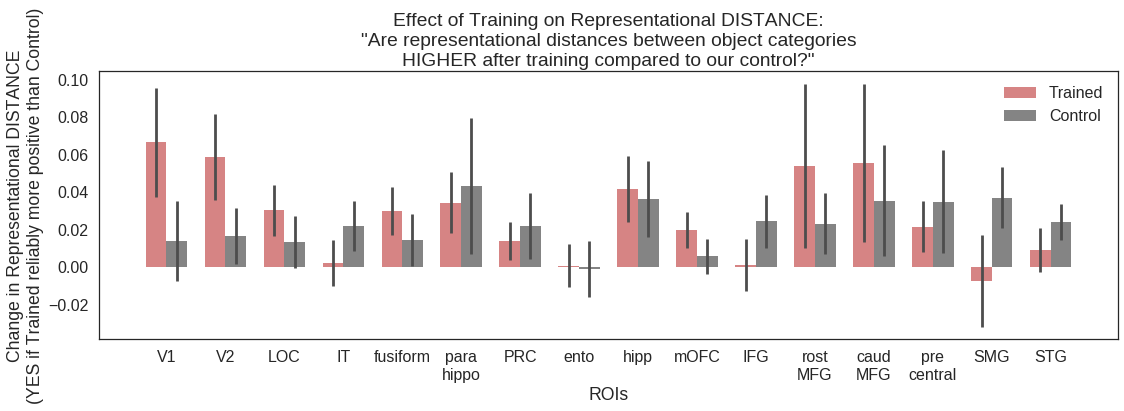

Saving figure to 'plots/differentiation_by_roi_group_mean.pdf'...
Done


In [24]:
## Generate summary plot (main analysis; old distance measure)

ROIs = ["V1", "V2", "LOC", "IT", "fusiform", "parahippo",  "PRC",  "ento", "hipp", 'mOFC', 'IFG', 'rostMFG', 'caudMFG', 'precentral', 'SMG', 'STG']
ROIs_formatted = ["V1", "V2", "LOC", "IT", "fusiform", "para\nhippo",  "PRC",  "ento", "hipp", 'mOFC', 'IFG', 'rost\nMFG', 'caud\nMFG', 'pre\ncentral', 'SMG', 'STG']

plot_indiv_subs = 0

sns.set_style('white')
sns.set_context('poster')

means_trained = Tradifflearn.mean(1)
std_trained = Tradifflearn.std(1)/np.sqrt(shape(Tradifflearn)[1])

means_control = Condifflearn.mean(1)
std_control = Condifflearn.std(1)/np.sqrt(shape(Condifflearn)[1])

fig, ax = plt.subplots(figsize=(len(ROIs),6))

n_groups = len(ROIs) # num ROIs
index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.8
error_config = {'ecolor': '0.3'}

print(index)

## plot means as bars
tcolor = (0.8,0.4,0.4)
rects1 = plt.bar(index, means_trained, bar_width,
                 alpha=opacity,
                 color=(0.8,0.4,0.4),
                 yerr=std_trained,
                 error_kw=error_config,
                 label='Trained')

ccolor = (0.4,0.4,0.4)
rects2 = plt.bar(index + bar_width, means_control, bar_width,
                 alpha=opacity,
                 color=(0.4,0.4,0.4),
                 yerr=std_control,
                 error_kw=error_config,
                 label='Control')

if plot_indiv_subs:
    ## now plot individual subjects as dots
    def generate_concat_tiled(array,reps):        
        inds = []
        for i in index:
            inds.append(np.tile(i,reps))
        return np.reshape(np.array(inds),(1,reps*len(array)))

    tindex = generate_concat_tiled(index,len(Tradifflearn[0]))
    tsubdists = np.reshape(Tradifflearn,(1,shape(Tradifflearn)[0]*shape(Tradifflearn)[1]))
    plt.scatter(tindex,tsubdists,s=25,alpha=0.2,color=tcolor)

    cindex = generate_concat_tiled(index,len(Condifflearn[0]))+bar_width
    csubdists = np.reshape(Condifflearn,(1,shape(Condifflearn)[0]*shape(Condifflearn)[1]))
    plt.scatter(cindex,csubdists,s=25,alpha=0.2,color=ccolor)

plt.xlabel('ROIs')
plt.ylabel('Change in Representational DISTANCE\n(YES if Trained reliably more positive than Control)')
plt.title('Effect of Training on Representational DISTANCE:\n"Are representational distances between object categories\nHIGHER after training compared to our control?"')
plt.xticks(index + bar_width / 2, ROIs_formatted)
plt.legend()
plt.tight_layout()
#plt.ylim((-.02, .1))
plt.show()

save_out = 1
if save_out:
    if plot_indiv_subs:
        helpers.save('plots/differentiation_by_roi_indiv_sub', ext='pdf', close=False, verbose=True)
    else:
        helpers.save('plots/differentiation_by_roi_group_mean', ext='pdf', close=False, verbose=True)



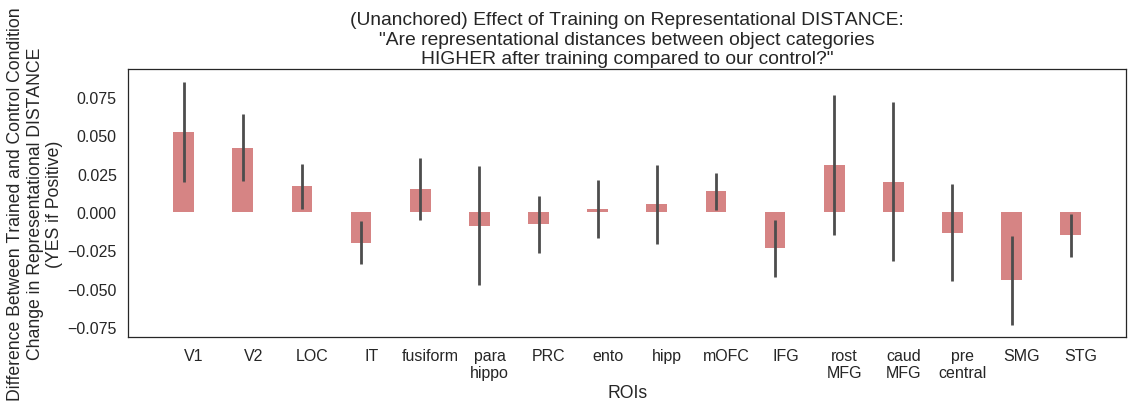

In [31]:
## Generate summary plot (main analysis)
plot_indiv_subs = 0

sns.set_style('white')
sns.set_context('poster')
#means_trained = Trained.mean(1)#Tradifflearn.mean(1)
#std_trained = Trained.std(1)/np.sqrt(shape(Trained)[1]) #Tradifflearn.std(1)/np.sqrt(shape(Tradifflearn)[1])

#means_control = Control.mean(1) #Condifflearn.mean(1)
#std_control = Control.std(1)/np.sqrt(shape(Control)[1]) #Condifflearn.std(1)/np.sqrt(shape(Condifflearn)[1])

diffdiff = Tradifflearn-Condifflearn #Trained - Control 

fig, ax = plt.subplots(figsize=(len(ROIs),6))

n_groups = len(ROIs) # num ROIs
index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.8
error_config = {'ecolor': '0.3'}

## plot means as bars
tcolor = (0.8,0.4,0.4)
rects1 = plt.bar(index, means_trained-means_control, bar_width,
                 alpha=opacity,
                 color=(0.8,0.4,0.4),
                 yerr=diffdiff.std(1)/np.sqrt(shape(diffdiff)[1]),
                 error_kw=error_config,
                 label='Trained')

ccolor = (0.4,0.4,0.4)
#rects2 = plt.bar(index + bar_width, means_control, bar_width,
#                 alpha=opacity,
##                 color=(0.4,0.4,0.4),
#                 yerr=std_control,
#                 error_kw=error_config,
#                 label='Control')

if plot_indiv_subs:
    ## now plot individual subjects as dots
    def generate_concat_tiled(array,reps):        
        inds = []
        for i in index:
            inds.append(np.tile(i,reps))
        return np.reshape(np.array(inds),(1,reps*len(array)))

    tindex = generate_concat_tiled(index,len(Tradifflearn[0]))
    tsubdists = np.reshape(Tradifflearn,(1,shape(Tradifflearn)[0]*shape(Tradifflearn)[1]))
    plt.scatter(tindex,tsubdists,s=25,alpha=0.2,color=tcolor)

    cindex = generate_concat_tiled(index,len(Condifflearn[0]))+bar_width
    csubdists = np.reshape(Condifflearn,(1,shape(Condifflearn)[0]*shape(Condifflearn)[1]))
    plt.scatter(cindex,csubdists,s=25,alpha=0.2,color=ccolor)

plt.xlabel('ROIs')
plt.title('(Unanchored) Effect of Training on Representational DISTANCE:\n"Are representational distances between object categories\nHIGHER after training compared to our control?"')
plt.ylabel('Difference Between Trained and Control Condition\nChange in Representational DISTANCE\n(YES if Positive)')
plt.xticks(index + bar_width / 2,  ROIs_formatted)
#plt.legend()
#plt.ylim((-.05, .05))

save_out = 0
if save_out:
    if plot_indiv_subs:
        helpers.save('plots/differentiation_by_roi_indiv_sub', ext='pdf', close=False, verbose=True)
    else:
        helpers.save('plots/differentiation_by_roi_group_mean', ext='pdf', close=False, verbose=True)

plt.tight_layout()
plt.show()

Anchoring Distance Measure

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


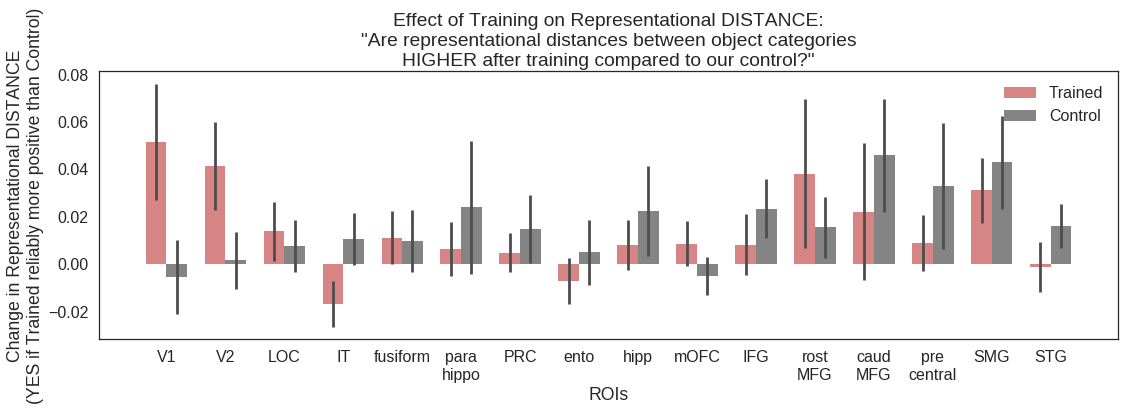

Saving figure to 'plots/differentiation_by_roi_group_mean.pdf'...
Done


In [32]:
## Generate summary plot (main analysis; old distance measure)

ROIs = ["V1", "V2", "LOC", "IT", "fusiform", "parahippo",  "PRC",  "ento", "hipp", 'mOFC', 'IFG', 'rostMFG', 'caudMFG', 'precentral', 'SMG', 'STG']
ROIs_formatted = ["V1", "V2", "LOC", "IT", "fusiform", "para\nhippo",  "PRC",  "ento", "hipp", 'mOFC', 'IFG', 'rost\nMFG', 'caud\nMFG', 'pre\ncentral', 'SMG', 'STG']

plot_indiv_subs = 0

sns.set_style('white')
sns.set_context('poster')

means_trained = Trained.mean(1)
std_trained = Trained.std(1)/np.sqrt(shape(Trained)[1]) 

means_control = Control.mean(1)
std_control = Control.std(1)/np.sqrt(shape(Control)[1]) 

fig, ax = plt.subplots(figsize=(len(ROIs),6))

n_groups = len(ROIs) # num ROIs
index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.8
error_config = {'ecolor': '0.3'}

print(index)

## plot means as bars
tcolor = (0.8,0.4,0.4)
rects1 = plt.bar(index, means_trained, bar_width,
                 alpha=opacity,
                 color=(0.8,0.4,0.4),
                 yerr=std_trained,
                 error_kw=error_config,
                 label='Trained')

ccolor = (0.4,0.4,0.4)
rects2 = plt.bar(index + bar_width, means_control, bar_width,
                 alpha=opacity,
                 color=(0.4,0.4,0.4),
                 yerr=std_control,
                 error_kw=error_config,
                 label='Control')

if plot_indiv_subs:
    ## now plot individual subjects as dots
    def generate_concat_tiled(array,reps):        
        inds = []
        for i in index:
            inds.append(np.tile(i,reps))
        return np.reshape(np.array(inds),(1,reps*len(array)))

    tindex = generate_concat_tiled(index,len(Tradifflearn[0]))
    tsubdists = np.reshape(Tradifflearn,(1,shape(Tradifflearn)[0]*shape(Tradifflearn)[1]))
    plt.scatter(tindex,tsubdists,s=25,alpha=0.2,color=tcolor)

    cindex = generate_concat_tiled(index,len(Condifflearn[0]))+bar_width
    csubdists = np.reshape(Condifflearn,(1,shape(Condifflearn)[0]*shape(Condifflearn)[1]))
    plt.scatter(cindex,csubdists,s=25,alpha=0.2,color=ccolor)

plt.xlabel('ROIs')
plt.ylabel('Change in Representational DISTANCE\n(YES if Trained reliably more positive than Control)')
plt.title('Effect of Training on Representational DISTANCE:\n"Are representational distances between object categories\nHIGHER after training compared to our control?"')
plt.xticks(index + bar_width / 2, ROIs_formatted)
plt.legend()
plt.tight_layout()
#plt.ylim((-.02, .1))
plt.show()

save_out = 1
if save_out:
    if plot_indiv_subs:
        helpers.save('plots/differentiation_by_roi_indiv_sub', ext='pdf', close=False, verbose=True)
    else:
        helpers.save('plots/differentiation_by_roi_group_mean', ext='pdf', close=False, verbose=True)

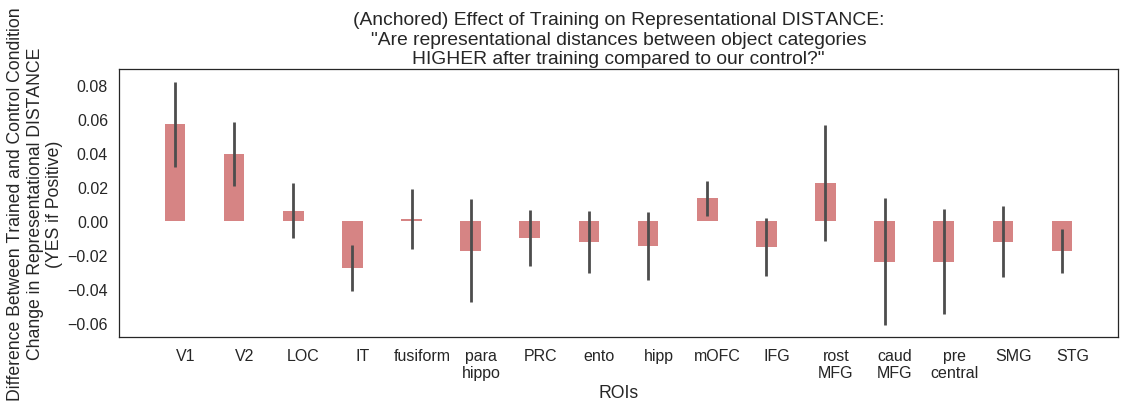

In [33]:
## Generate summary plot (main analysis)
plot_indiv_subs = 0

sns.set_style('white')
sns.set_context('poster')

means_control = Control.mean(1)
std_control = Control.std(1)/np.sqrt(shape(Control)[1]) 

diffdiff = Trained - Control 

fig, ax = plt.subplots(figsize=(len(ROIs),6))

n_groups = len(ROIs) # num ROIs
index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.8
error_config = {'ecolor': '0.3'}

## plot means as bars
tcolor = (0.8,0.4,0.4)
rects1 = plt.bar(index, means_trained-means_control, bar_width,
                 alpha=opacity,
                 color=(0.8,0.4,0.4),
                 yerr=diffdiff.std(1)/np.sqrt(shape(diffdiff)[1]),
                 error_kw=error_config,
                 label='Trained')

ccolor = (0.4,0.4,0.4)
#rects2 = plt.bar(index + bar_width, means_control, bar_width,
#                 alpha=opacity,
##                 color=(0.4,0.4,0.4),
#                 yerr=std_control,
#                 error_kw=error_config,
#                 label='Control')

if plot_indiv_subs:
    ## now plot individual subjects as dots
    def generate_concat_tiled(array,reps):        
        inds = []
        for i in index:
            inds.append(np.tile(i,reps))
        return np.reshape(np.array(inds),(1,reps*len(array)))

    tindex = generate_concat_tiled(index,len(Tradifflearn[0]))
    tsubdists = np.reshape(Tradifflearn,(1,shape(Tradifflearn)[0]*shape(Tradifflearn)[1]))
    plt.scatter(tindex,tsubdists,s=25,alpha=0.2,color=tcolor)

    cindex = generate_concat_tiled(index,len(Condifflearn[0]))+bar_width
    csubdists = np.reshape(Condifflearn,(1,shape(Condifflearn)[0]*shape(Condifflearn)[1]))
    plt.scatter(cindex,csubdists,s=25,alpha=0.2,color=ccolor)

plt.xlabel('ROIs')
plt.title('(Anchored) Effect of Training on Representational DISTANCE:\n"Are representational distances between object categories\nHIGHER after training compared to our control?"')
plt.ylabel('Difference Between Trained and Control Condition\nChange in Representational DISTANCE\n(YES if Positive)')
plt.xticks(index + bar_width / 2,  ROIs_formatted)
#plt.legend()
#plt.ylim((-.05, .05))

save_out = 0
if save_out:
    if plot_indiv_subs:
        helpers.save('plots/differentiation_by_roi_indiv_sub', ext='pdf', close=False, verbose=True)
    else:
        helpers.save('plots/differentiation_by_roi_group_mean', ext='pdf', close=False, verbose=True)

plt.tight_layout()
plt.show()

In [35]:
###### Variant of analysis ***ignoring training condition***, and just looking at overall change in between vs. within 
###### object similarity.

run_this = 0
if run_this:
    Witpre = []
    Btwpre = []
    Witpost = []
    Btwpost = []
    Diffpre = []
    Diffpost = []

    ROIs = ['V1','fusiform','paraphippo','IT','LOC','occitemp']

    for roi in ROIs:
        print(roi)
        _Witpre = []
        _Btwpre = []
        _Witpost = []
        _Btwpost = []
        _Diffpre = []
        _Diffpost = []
        for s in sub_dirs:
            wit_pre,btw_pre = compare_btw_wit_obj_similarity_across_runs(s,'pre',roi)
            wit_post,btw_post = compare_btw_wit_obj_similarity_across_runs(s,'post',roi)
            _Diffpre.append(btw_pre-wit_pre)
            _Diffpost.append(btw_post-wit_post)    
            _Witpre.append(wit_pre)
            _Btwpre.append(btw_pre)
            _Witpost.append(wit_post)
            _Btwpost.append(btw_post)    

        _Witpre,_Btwpre,_Witpost,_Btwpost,_Diffpre,_Diffpost = map(np.array,[_Witpre,_Btwpre,_Witpost,_Btwpost,_Diffpre,_Diffpost])

        if len(Witpre)==0:
            Witpre = _Witpre
            Btwpre = _Btwpre
            Witpost = _Witpost
            Btwpost = _Btwpost
            Diffpre = _Diffpre
            Diffpost = _Diffpost
        else:
            Witpre = np.vstack((Witpre,_Witpre))
            Btwpre = np.vstack((Btwpre,_Btwpre))   
            Witpost = np.vstack((Witpost,_Witpost))
            Btwpost = np.vstack((Btwpost,_Btwpost)) 
            Diffpre = np.vstack((Diffpre,_Diffpre))
            Diffpost = np.vstack((Diffpost,_Diffpost))         